# Projeto de Previsão de Vendas
![Cabeçalho](img/rossmann_2.png)

## 0.0 Imports


In [1]:
import inflection
import math
import datetime
import random
import pickle

import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import xgboost           as xgb 

from scipy                 import stats 
from IPython.display       import Image
from matplotlib.gridspec   import GridSpec 
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder 
from sklearn.ensemble      import RandomForestRegressor 
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error  
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.ensemble      import RandomForestRegressor



### 0.1 Helper Functions

In [2]:
# calcular o CramerV, que calcula as correlações de atributos categoricos
# definindo como função para ser apliucado outras vezes
def cramer_v(x, y):
    # calculando a CM (confusion metrics)
    cm = pd.crosstab(x, y).values

    # soma de todos os valores
    n = cm.sum()

    # numero de linhas e colunas
    r, k = cm.shape

    # calculando o chi2
    chi2 = stats.chi2_contingency( cm )[0]

    # correção do chi2
    chi2_corre = max(0, chi2 - (k-1) * (r-1) / (n-1) )
    k_corre = k - (k-1)**2 / (n-1)
    r_corre = r - (r-1)**2 / (n-1)

    #calcular o V cramer
    return np.sqrt( ( chi2_corre / n ) / ( min (k_corre-1, r_corre-1) )  )


def ml_error (model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame (  {'Model Name': model_name,
                            'MAE': mae,
                            'MAPE': mape,
                            'RMSE': rmse}, index=[0])

def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mae_list = []
    mape_list = []
    rmse_list = []


    for k in reversed( range(1, kfold+1) ):
        if verbose:
            print(f'KFold Number: {k}')
           
        # star and end date for validation
        # primeiras 6 semanas
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        # utimas datas
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)
    
        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]
    
        # training and validation dataset
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']
    
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']
    
        # model
        m = model.fit( xtraining, ytraining )
    
        # prediction
        yhat = m.predict( xvalidation )
    
        # performance
        m_result = ml_error(model_name, np.expm1( yvalidation ), np.expm1( yhat ) )
    
        # store performance of each kfold interation
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
    
        # dataframe com os resultados (média e desvio padrão) e o nome do model utilizado
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE - Mean/Std': np.round( np.mean(mae_list), 2 ).astype( 'str' ) + '  +/-  ' + np.round( np.std(mae_list), 2 ).astype( 'str' ),
                          'MAPE - Mean/Std': np.round( np.mean(mape_list), 2 ).astype( 'str' ) + '  +/-  ' + np.round( np.std(mape_list), 2 ).astype( 'str' ),
                          'RMSE - Mean/Std': np.round( np.mean(rmse_list), 2 ).astype( 'str' ) + '  +/-  ' + np.round( np.std(rmse_list), 2 ).astype( 'str' )}, index=[0])



### 0.2 Loading data


In [3]:
# importando os dados aramazenados no computador 
df_sales_raw = pd.read_csv('train.csv')
df_store_raw = pd.read_csv('store.csv')

# merge
df_raw = pd.merge (df_sales_raw, df_store_raw, how= 'left', on= 'Store');

/var/folders/5q/g0x8rcyn6x17pcrrtzhh8vs80000gn/T/ipykernel_1725/1011669297.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sales_raw = pd.read_csv('train.csv')


## 1.0 Descrição dos Dados 

In [4]:
# Cópia de segurança da seção
df1=df_raw.copy() 

### 1.1 Renomeando as colunas


In [12]:
# plotando o nome de todas as colunas do dataset
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [5]:
# atribuindo os nomes antigos das colunas
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

# criação de uma função para mudar os antigos nomes das colunas e passar para um novo formato, sendo tudo com letra minuscula e separado por " _ " 
snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# renomeando as colunas
df1.columns = cols_new

### 1.2 Dimensão do Dataset

In [6]:
# olhando a quantidade de linhas e colunas
rows_ = df1.shape[0]
cols_ = df1.shape[1]

print( f'Number of rows: {rows_}')
print (f'Number od cols: {cols_}')

Number of rows: 1017209
Number od cols: 18


### 1.3 Tipos de dados

In [26]:
# verificanto o tipo dos dados do dataset e mudando os necessários
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [7]:
# mudando o tipo de dado da coluna 'date' para datetime
df1['date'] = pd.to_datetime(df1['date'])

### 1.4 Checando os dados faltantes - Na's


In [28]:
# verificando a quantidade de Na's existentes em cada coluna do dataset
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.5  Tratando os dados faltantes - NA's



In [8]:
# colunas que possuem NA's:
# "competition_distance" = onde susbtitiu os NA's por um valor maximo de 200000.0 como se nao pudesse ser uma loja competitiva pela distancia muito grande
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan( x ) else x)

# "competition_open_since_month" = onde se substitui o NA  pela data da coluna "date" extraindo o mes
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x ['competition_open_since_month'], axis=1)

# "competition_open_since_year"  = onde se substui o NA f pela data da coluna "date" extraindo o ano
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x ['competition_open_since_year'], axis=1)

# "promo2_since_week" = onde se substitui o NA pela data da coluna "date" extraindo a semana do ano 
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x ['promo2_since_week'], axis=1)

# "promo2_since_year" = onde se substitui o NA pela data da coluna "date" extraindo o ano 
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x ['promo2_since_year'], axis=1)

# "promo_interval" =  criação de uma lista com os meses para ser preenchida baseado com o mes da coluna 'date'
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True )
df1['month_map']= df1['date'].dt.month.map(month_map)

# crianção de uma nova coluna 'is_promo' a fim de saber se o month_map do calendario da a loja esta da promoção ou não
df1['is_promo'] = df1[['promo_interval' , 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else  1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

### 1.6 Mudando tipos de dados

In [35]:
# checando novamente os tipos de dados apos a operação de tranformação dos dados faltantes 
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [15]:
# mudando o tipo dos dados para 'int':

#competions 
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

#promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

#state_holiday, store_type e assortment - mudando de object pata str
df1['state_holiday'] = df1['state_holiday'].astype(str)
df1['store_type'] = df1['store_type'].astype(str)
df1['assortment'] = df1['assortment'].astype(str)



#df1['month_map'] = df1['month_map'].astype(str)

#df1['promo_interval'] = df1['promo_interval'].astype(str)

### 1.7 Estatística Descritiva

In [17]:
# criar dois bancos de dados separado em dados categoricos e numericos
num_atributes = df1.select_dtypes(include=['int64', 'float64'])
cat_atributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

#### 1.7.1 Dados Númericos


In [13]:
# realização da analise descritiva dos dados numericos 

# análise de tendencia central (média e mediana)
ct1 =  pd.DataFrame(num_atributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_atributes.apply(np.median)).T 

# analise de disperção ( std, min, max, range, skew, kurtosis)
d1= pd.DataFrame(num_atributes.apply(np.std)).T
d2= pd.DataFrame(num_atributes.apply(min)).T
d3= pd.DataFrame(num_atributes.apply(max)).T
d4= pd.DataFrame(num_atributes.apply(lambda x: x.max() - x.min())).T
d5= pd.DataFrame(num_atributes.apply(lambda x: x.skew())).T
d6= pd.DataFrame(num_atributes.apply(lambda x: x.kurtosis())).T

# concatenação dos DataFrames 
metrics = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
metrics.columns = [ 'atributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]

In [24]:
# plotando todas as metricas da analise descritiva dos dados numericos 
metrics 

,atributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<Axes: xlabel='sales', ylabel='Count'>

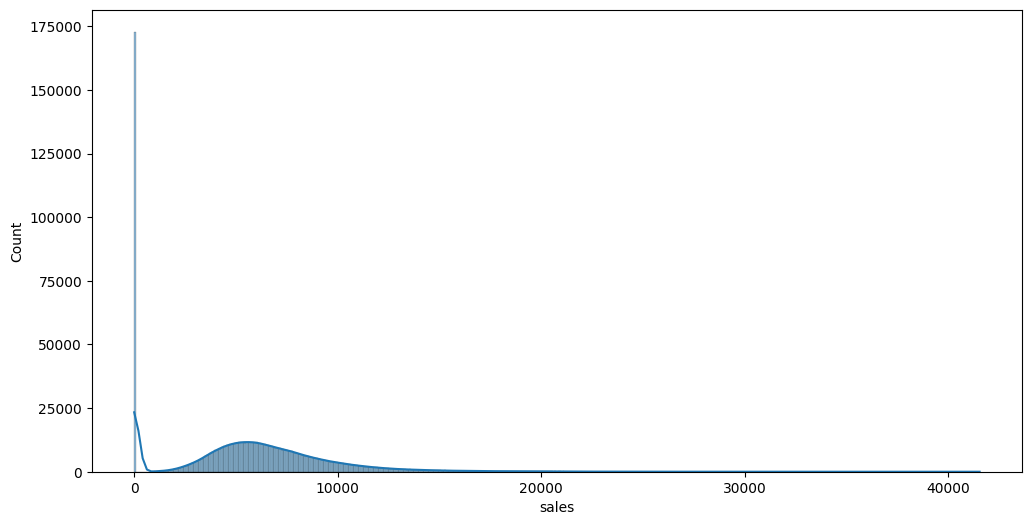

In [46]:
# plotando grafico de distribuição das vendas ('sales')
plt.figure(figsize=(12,6))
sns.histplot(df1['sales'], kde=True, alpha=0.5)


<Axes: xlabel='customers', ylabel='Count'>

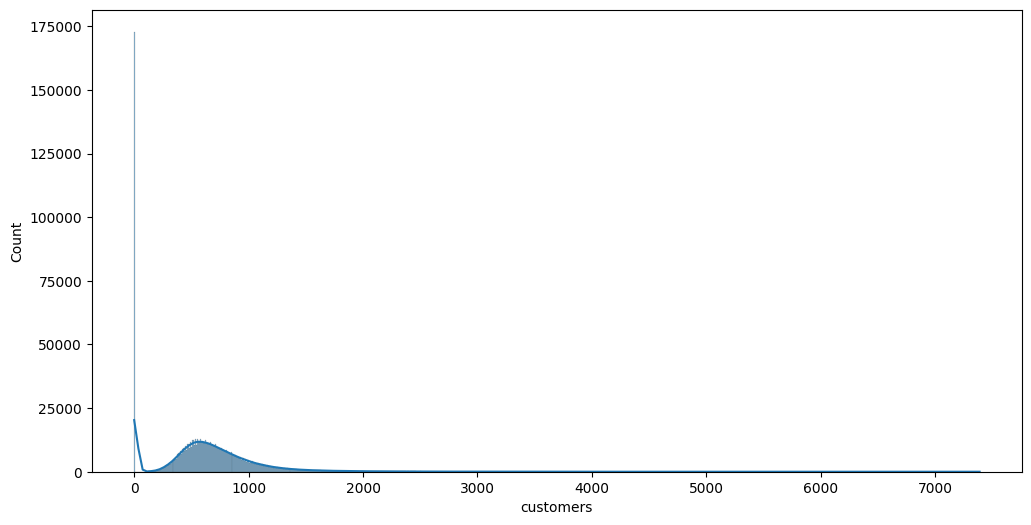

In [47]:
# plotando grafico de distribuição dos clientes ('customers')
plt.figure(figsize=(12,6))
sns.histplot(df1['customers'], kde=True, alpha=0.5)

#### 1.7.2 Dados Categoricos 

In [12]:
# verificação de quantidade varaivel cada categoria tem
cat_atributes.apply(lambda x: x.unique().shape[0])


state_holiday      5
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

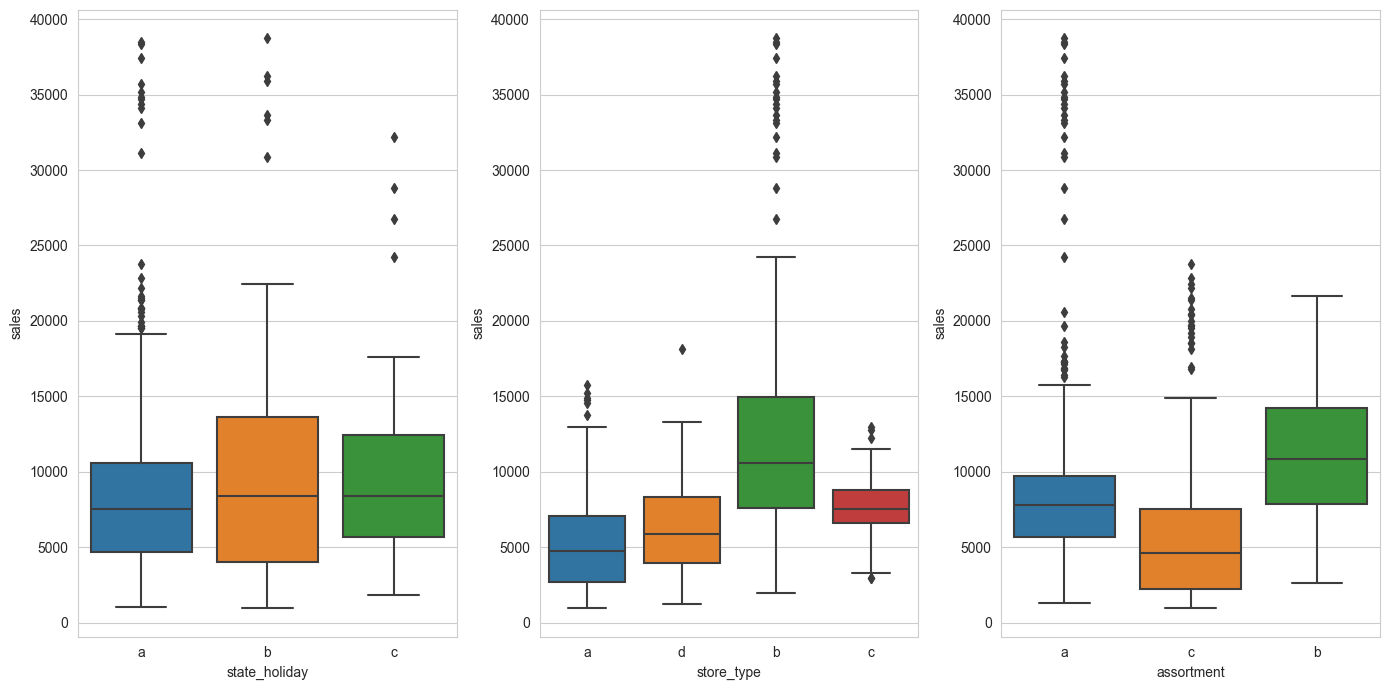

In [20]:
# filtro para tirar dados acomulados dos dias em q não teve vendas
aux1= df1[ (df1['state_holiday'] != '0' ) & (df1['sales'] > 0)] 

# para fazer análise de dados categorios foi usado o boxplot para visulaização das analises de tendencia central

# configuraçao do tamanho e estilo do gráfico
sns.set_style("whitegrid")
plt.figure(figsize=(14,7))

plt.subplot(1, 3, 1)
sns.boxplot (x= 'state_holiday', y= 'sales', data= aux1)

plt.subplot (1, 3, 2)
sns.boxplot (x= 'store_type', y= 'sales', data= aux1)

plt.subplot (1, 3, 3)
sns.boxplot (x= 'assortment', y= 'sales', data= aux1)

# ajustando o espaço entre os gráficos
plt.tight_layout()


## 2.0 Feature Engineering


In [21]:
# criando uma cópia de segurança
df2 = df1.copy()

### 2.0.1 Image

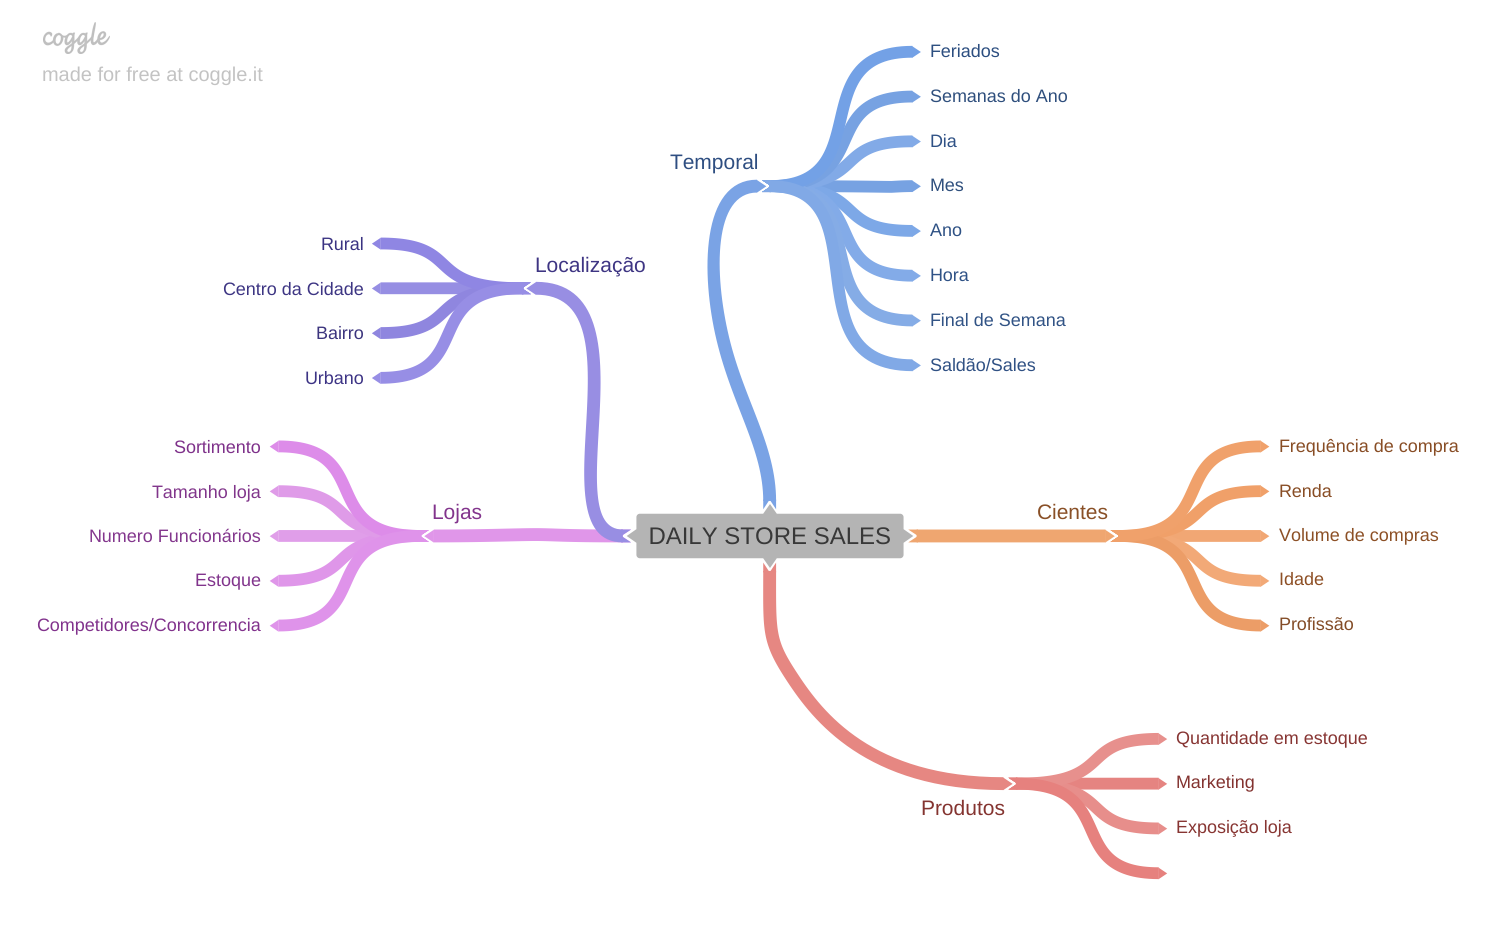

In [23]:
# importando o mapa mental das hipoteses geradas atraves do fenomeno a ser explorado
Image('img/mind_map_hip.png')

### 2.1 Criação Hipoteses


#### 2.1.1 Hipoteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais. 

**2.** Lojas com maior capacidade de estoque deveriam vender mais. 

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos. 

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

#### 2.1.2 Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais. 

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

#### 2.1.3 Hipoteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais. 2. Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5**. Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

#### 2.1.4 Hipoteses Clientes

#### 2.1.5 Hipoteses Localização

### 2.2 Priorização de  Hipoteses (Lista final)


**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais. 

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

### 2.3 Feature Engineering

In [22]:
# Derivação de algumas variaveis originais:

# extraindo as datas e criando uma coluna para year, month, day, week of year e year week
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day 
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


# calculando o tempo de duração da competições e promoções 

#competition since - união das datas 'competition_open_since_year' e 'competitiom_open_since_month' :
df2['competiton_since'] = df2.apply(lambda x: datetime.datetime(year = x ['competition_open_since_year'], month = x ['competition_open_since_month'], day = 1 ), axis=1)

# calculo do tempo, por meses, da competição
df2['competition_time_month'] = ( (df2['date'] - df2['competiton_since'])/30 ).apply(lambda x: x.days).astype(int)

# promo since - união de promo2_since_year com promo2_since_week
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

#converter para uma data
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days=7 ) )

# subtrair as datas 
df2['promo_time_week'] = ( (df2['date'] - df2['promo_since'])/7 ).apply (lambda x: x.days).astype(int)


# mapeamento dos valores das colunas 'assortment' e 'state_oliday'
# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#state holiday 
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'chistmmas' if x == 'c' else 'regular_day')

## 3.0 Filtragem de Variáveis 

In [23]:
# copia de segurança 
df3=df2.copy( )

### 3.1 Filtragem da linhas

In [24]:
# filtrando as linhas que nao te valores que irao agregar na predição 
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

### 3.2 Seleção das colunas

In [25]:
# exclusao de colunas que não irão agregar na predição ou que é uma restrição de negócio onde não se tera os dados futuros 

cols_drop = ['customers', 'open', 'promo_interval', 'month_map'] 
df3 = df3.drop(cols_drop, axis=1)

## 4.0 Análise Exploratória dos Dados

In [26]:
# cópia de segurança
df4=df3.copy()

### 4.1 Análise Univariada

#### 4.1.1 Response Variable

/var/folders/5q/g0x8rcyn6x17pcrrtzhh8vs80000gn/T/ipykernel_1725/2097592184.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df4['sales']);


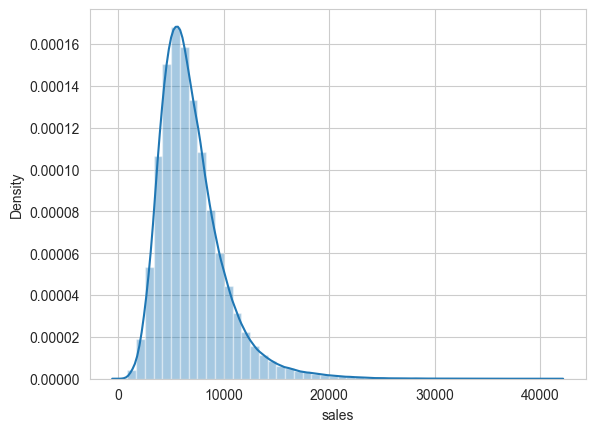

In [27]:
# plotando a distribuição da variavel sales
sns.distplot(df4['sales']);

#### 4.1.2 Variáveis Numéricas

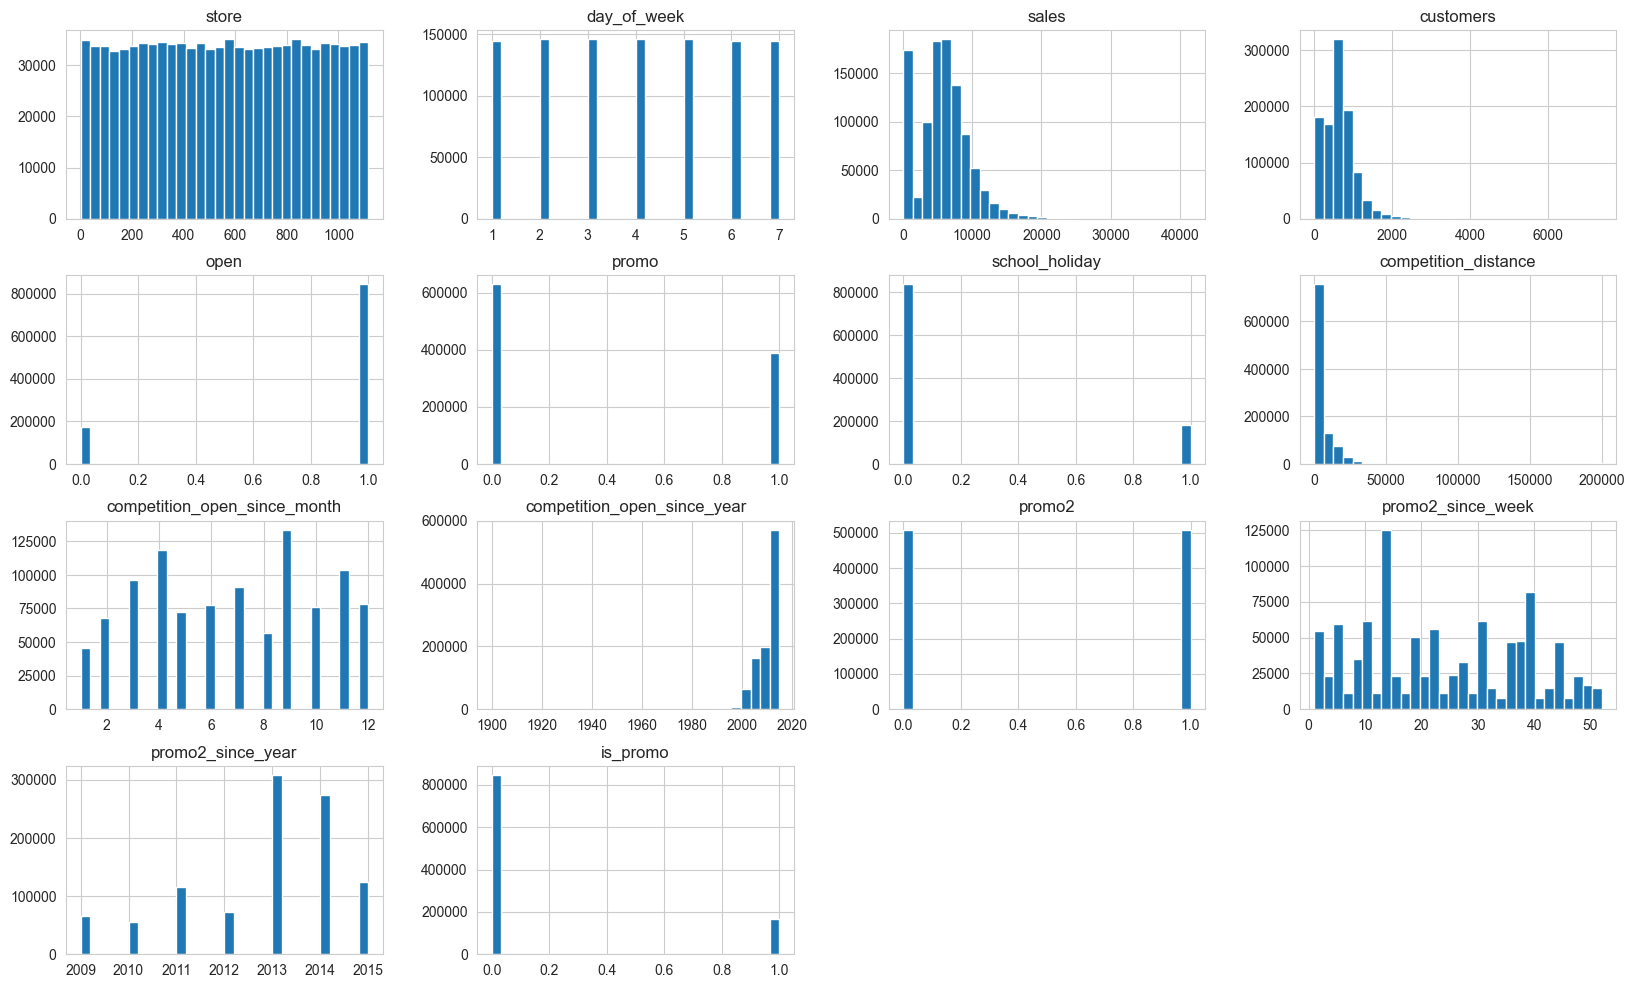

In [28]:
# plotando um histograma de todas as variaveis numéricas 
num_atributes.hist(bins=30,figsize=(20, 12));

#### 4.1.3 Variáveis Categoricas

In [29]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         chistmmas
Name: state_holiday, dtype: object

/var/folders/5q/g0x8rcyn6x17pcrrtzhh8vs80000gn/T/ipykernel_1725/2228916541.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label= 'public_holiday', shade=True)
/var/folders/5q/g0x8rcyn6x17pcrrtzhh8vs80000gn/T/ipykernel_1725/2228916541.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label= 'easter_holiday', shade=True)
/var/folders/5q/g0x8rcyn6x17pcrrtzhh8vs80000gn/T/ipykernel_1725/2228916541.py:18: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot( df4[df4['state_holiday'] == 'chistmmas']['sales'], labe

<Axes: xlabel='sales', ylabel='Density'>

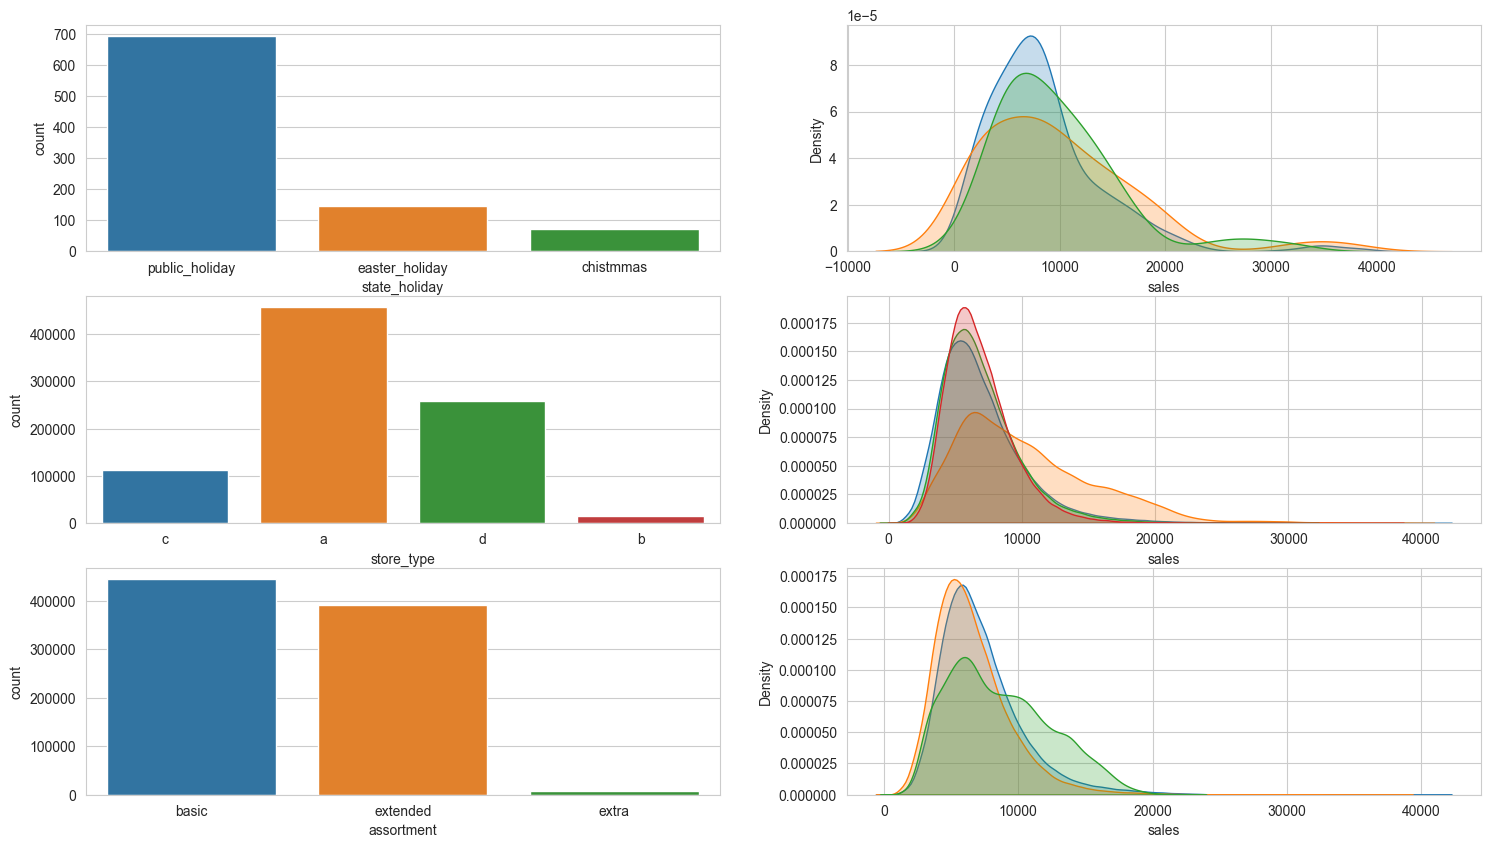

In [30]:
# state_holiday 
#filtrando para melhor visualização no grafico
holiday = df4[df4['state_holiday'] != 'regular_day']
#plotando o grafico
plt.figure(figsize=(18, 10))
plt.subplot(3, 2, 1)
sns.countplot(x='state_holiday', data=holiday)

#separando as vendas por feriado:
# public_holiday
plt.subplot(3, 2, 2)
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label= 'public_holiday', shade=True)

# easter_holiday
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label= 'easter_holiday', shade=True)

# chistmmas
sns.kdeplot( df4[df4['state_holiday'] == 'chistmmas']['sales'], label= 'chistmmas', shade=True)


# store_type
# plotando o grafico de store_type
plt.subplot(3, 2, 3)
sns.countplot(x='store_type', data=df4)
# separando as vendas por cada tipo de loja e plotando o gráfico:
plt.subplot(3, 2, 4)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label= 'a', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label= 'b', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label= 'c', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label= 'd', shade=True)



#assorment
# plotando o gráfico do assorment
plt.subplot(3, 2, 5)
sns.countplot(x='assortment', data=df4)
# separando as vendas por caada tipo de sortimento:
plt.subplot(3, 2, 6)
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label= 'extended', shade=True)
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label= 'basic', shade=True)
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label= 'extra', shade=True)


### 4.2 Análise Bivariada

 Análisando todas as hipoteses da lista final : 

#### **H1.** Lojas com maior sortimentos deveriam vender mais.

**FALSO** Lojas com MAIOR SORTIMENTO vendem MENOS

<Axes: xlabel='year_week'>

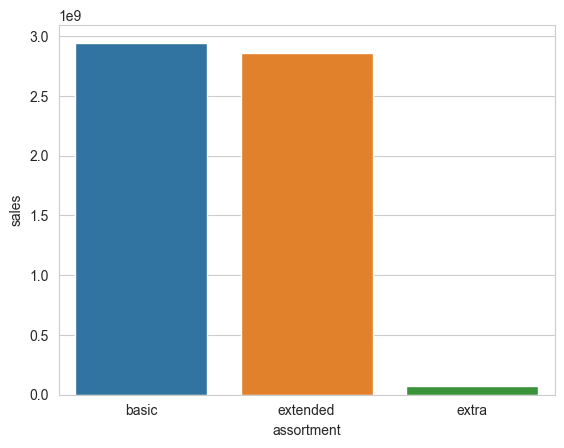

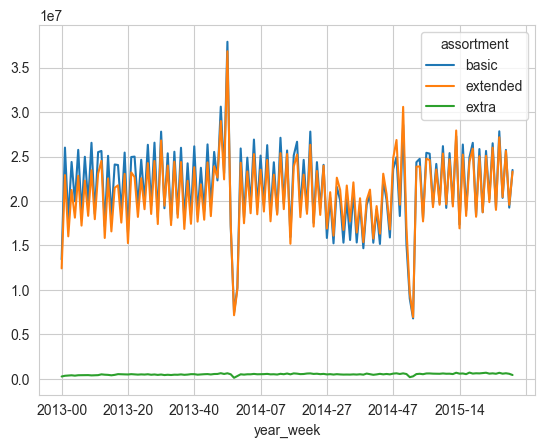

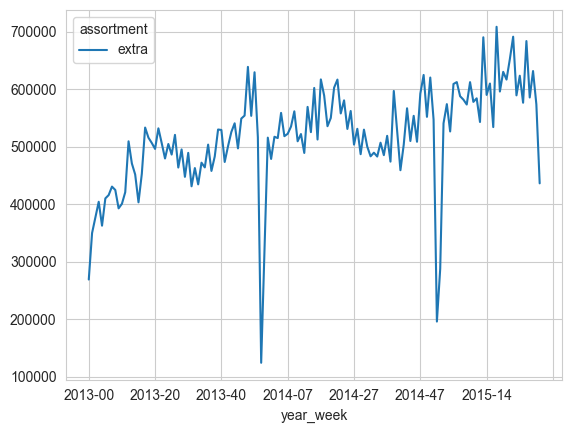

In [31]:
# verificando a quantidade de vendas por tipo de sortimento das lojas
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1)

# verificando as vendar por tipo de sortimentos durante as semanas dos anos 
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values= 'sales').plot()

# verificando se o tipo de assortment = 'extra' vende mais 
aux3 = aux2[aux2['assortment']== 'extra']
aux3.pivot(index='year_week', columns='assortment', values= 'sales').plot()


#### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**FALSO** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS

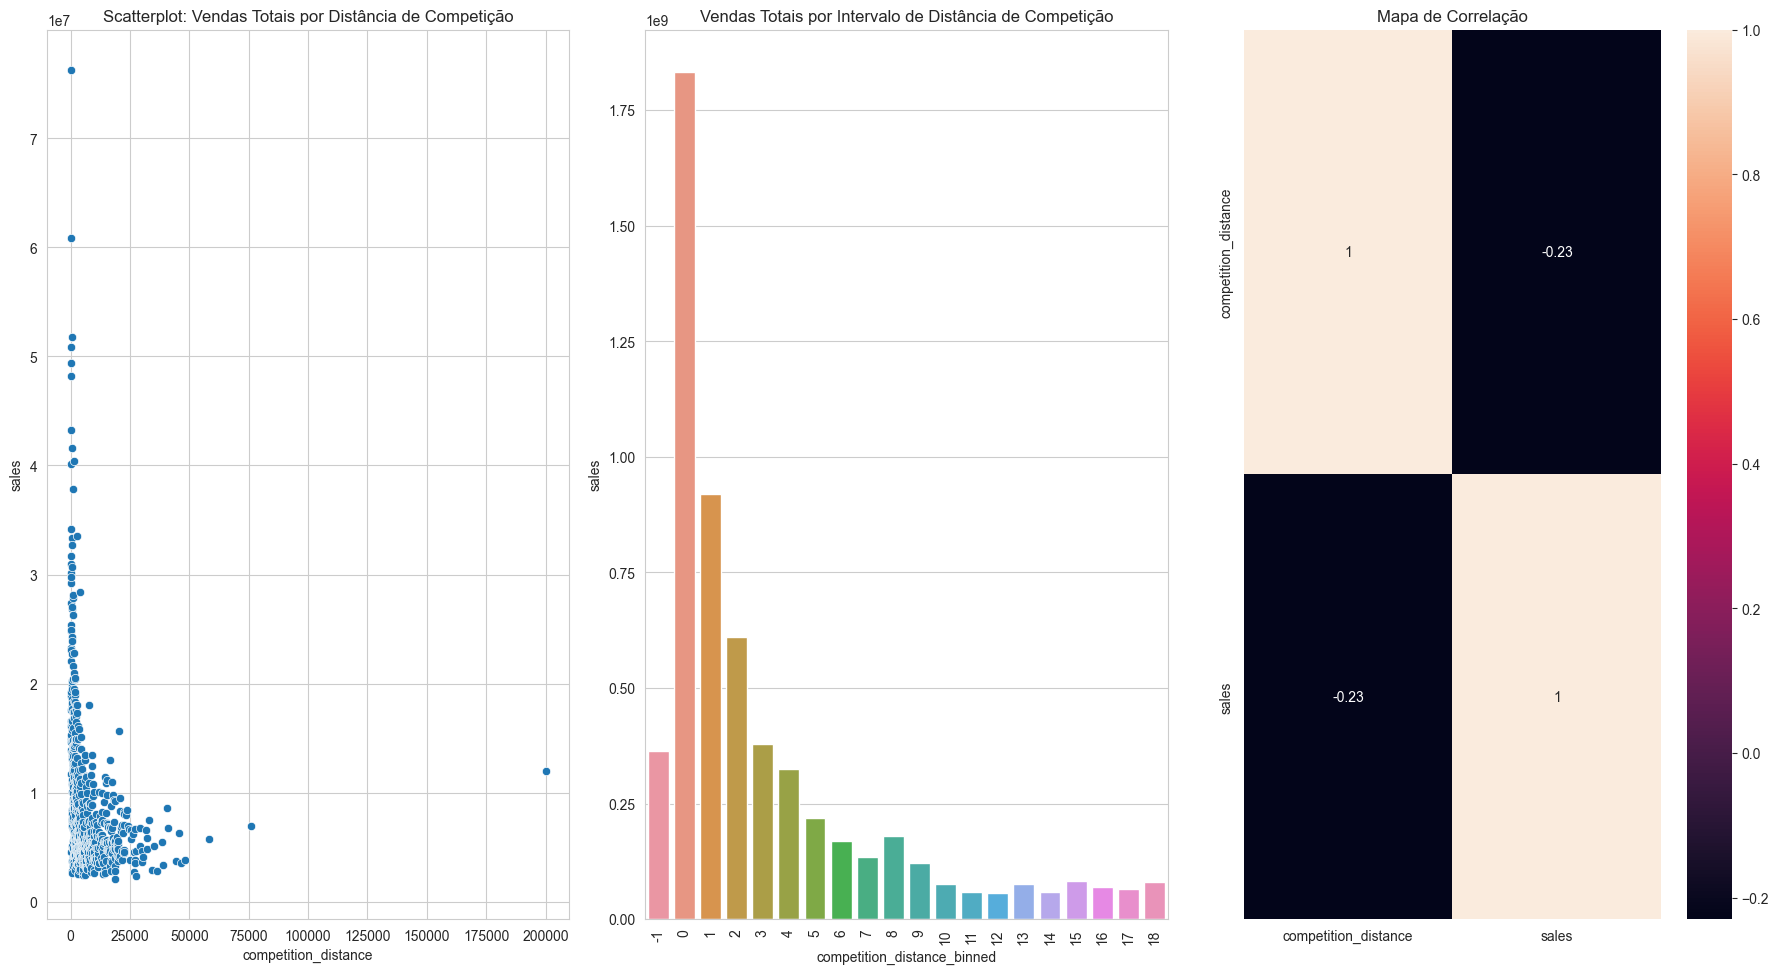

In [32]:
# Verificando a quantidade de vendas por cada distância de competição
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

# Plotando os dados com scatterplot
plt.figure(figsize=(18, 10))
plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)
plt.title('Scatterplot: Vendas Totais por Distância de Competição')

# Plotando um mapa de correlação
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)
plt.title('Mapa de Correlação')

# Criação de bins, criando grupos de distância para melhorar a visualização e análise
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins).cat.codes
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

# Convertendo os Interval objects em strings legíveis
aux2['competition_distance_binned'] = aux2['competition_distance_binned'].astype(str)

# Criando um coluna com a distância agrupada com bins e plotando o gráfico
plt.subplot(1, 3, 2)
sns.barplot(x='competition_distance_binned', y='sales', data=aux2)
plt.title('Vendas Totais por Intervalo de Distância de Competição')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


#### **H3.** Lojas com competidores à mais tempo deveriam vendem mais.
**FALSO** Lojas com COMPETIDORES à MAIS TEMPO vendem MENOS.


<Axes: >

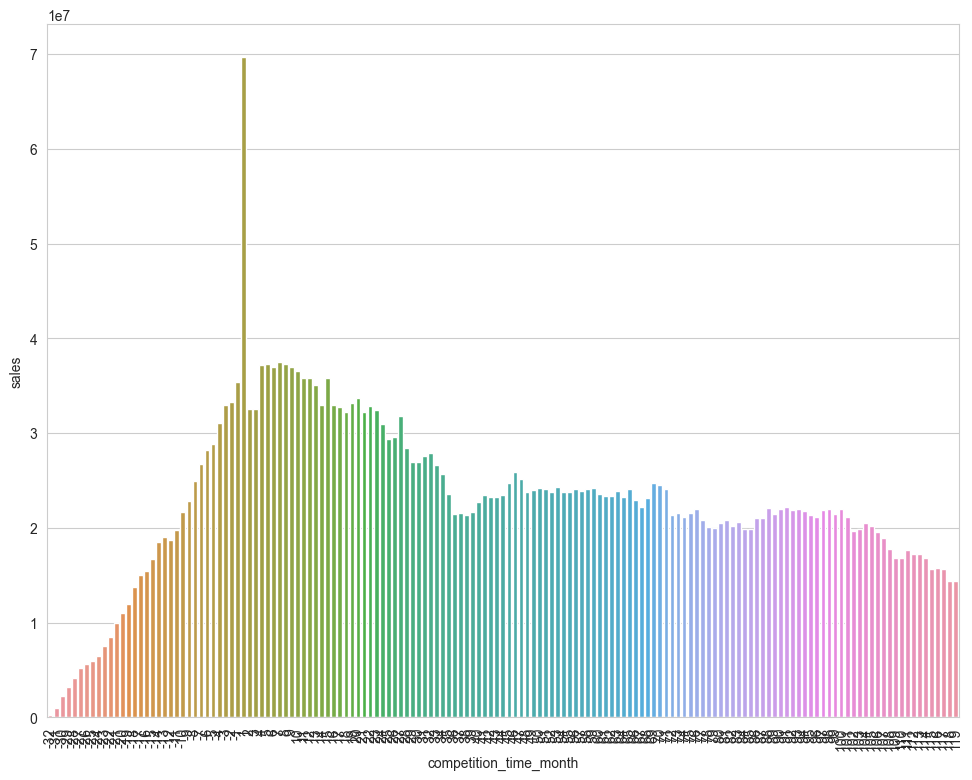

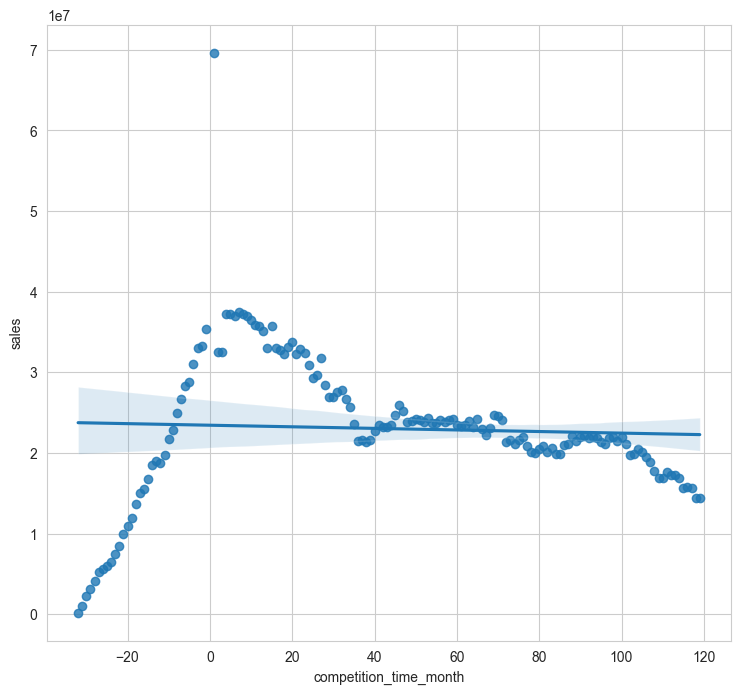

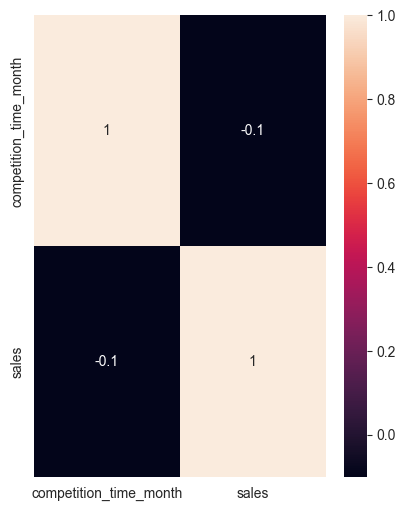

In [33]:
# verificando a quantidade das vendas com o tempo das competições 
plt.figure(figsize=(40, 9))
plt.subplot(1, 3, 1)
aux1=df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2=aux1[(aux1['competition_time_month']<120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.figure(figsize=(30, 8))
plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

# análise de correlação entre a competition time month com sales 
plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)


#### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSO** Lojas com PROMOÇÕES ATIVAS por MAIS tempo VENDEM MENOS, depois de um certo período

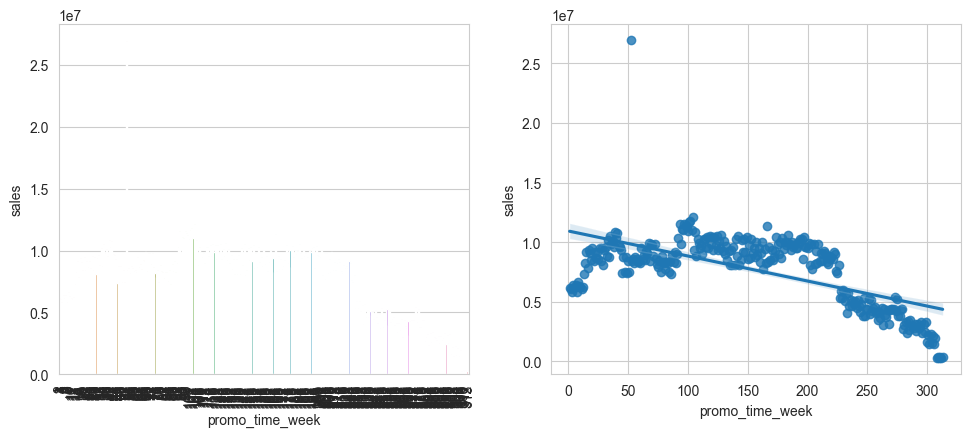

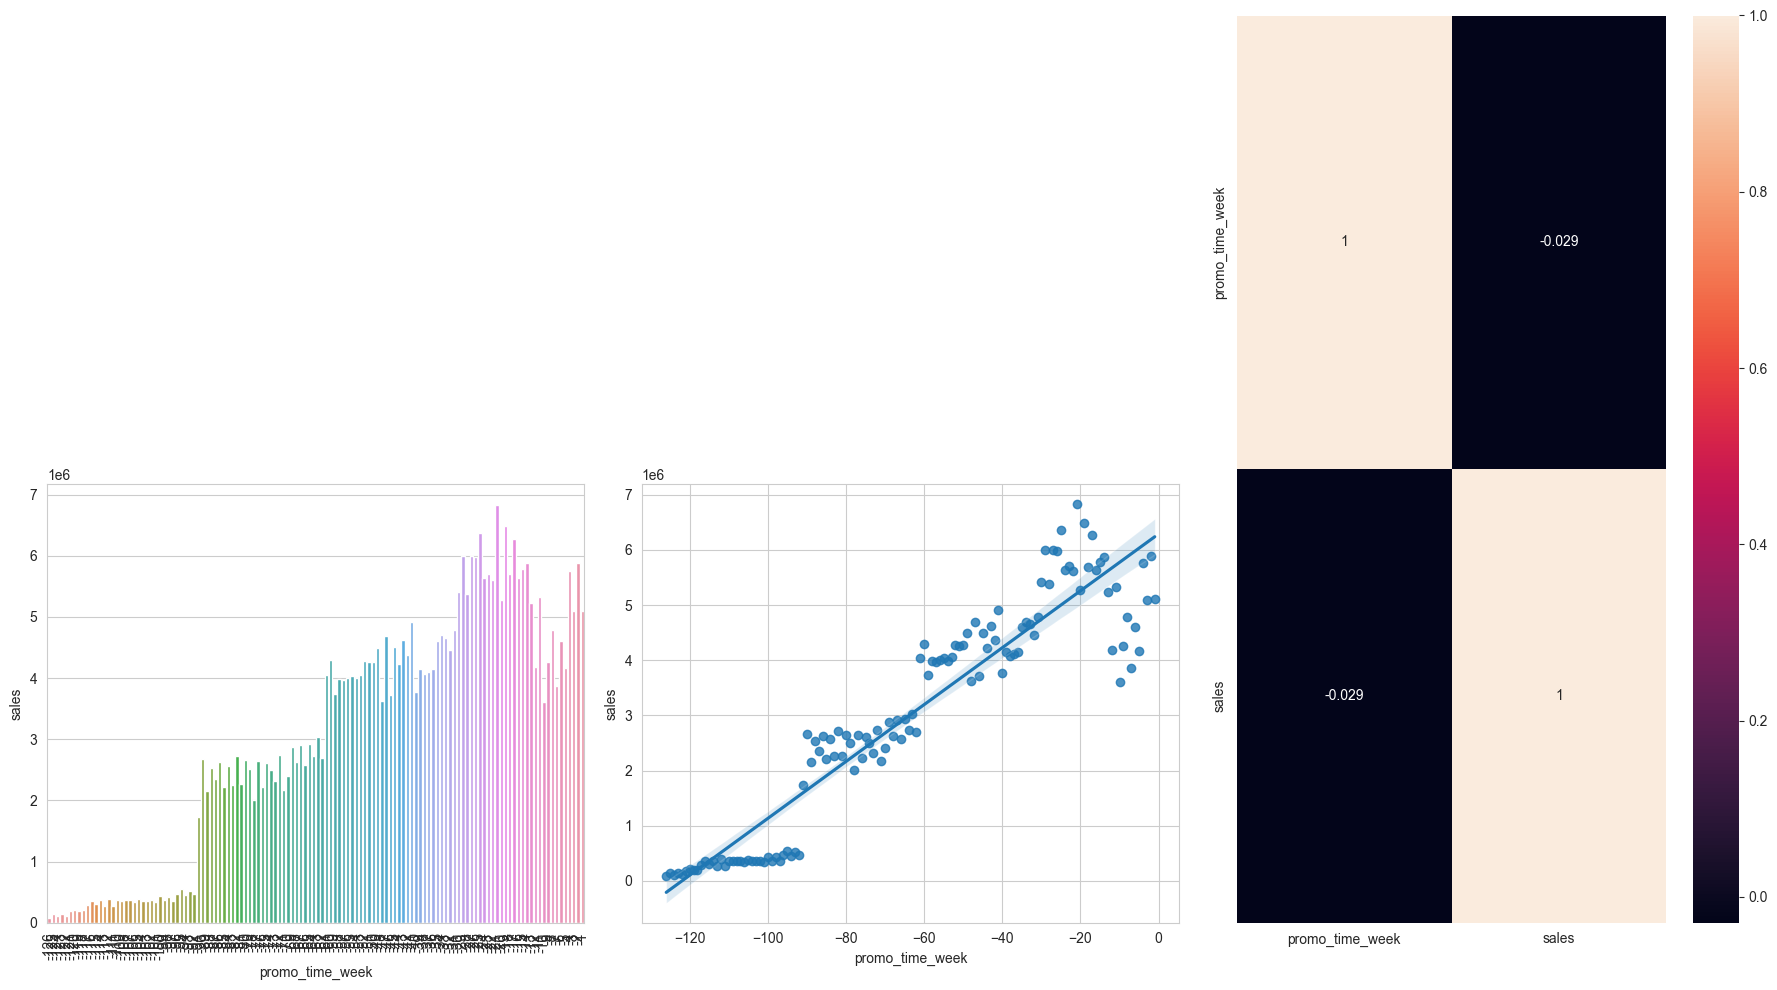

In [34]:
# verificando a quantidade de vendas por tempo de promoção ativa
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

#grid=GridSpec(2, 3, width_ratios=[2, 1, 1], height_ratios=[2, 2])
grid = GridSpec (2, 3)

#filtragem das promo em extentido e regular para melhor visualização do fenomeno
# promo extendido
plt.figure(figsize=(18, 10))
plt.subplot(grid[0,0])
aux2=aux1[aux1['promo_time_week'] > 0]
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);


# promo regular
plt.figure(figsize=(18, 10))
plt.subplot(grid[1,0])
aux3=aux1[aux1['promo_time_week'] < 0] 
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

# fazendo a correlação 
plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(method='pearson'), annot=True)
           
plt.tight_layout()
plt.show()

<s> #### **H5.** Lojas com mais dias de promoção deveriam vender mais.<s/>
    
    **validação sera feita no segundo ciclo**

#### **H6.** Lojas com mais promoções consecutivas deveriam vender mais. 
**FALSA** Lojas com promoções consecultivas VENDEM MENOS.

In [35]:
# olhando o volume de vendas de acordo com a participação das lojas na promo ou promo2

aux1=df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()


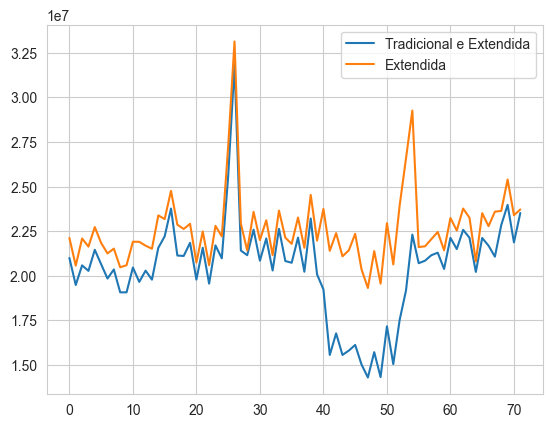

In [36]:
# verificando as vendas das lojas que participaram da promo(tradicional) e promo2(extendida)

aux1 = df4[(df4['promo']==1) & (df4['promo2']==1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax=aux1.plot()

# verificando as vendas que participaram da promo2 (extendida) e não participaram da promo (tradicional)
aux2 = df4[(df4['promo']==1) & (df4['promo2']==0)][['year_week', 'sales']].groupby('year_week').sum(). reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional e Extendida', 'Extendida'])

#### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSO** Lojas NÃO VENDEM mais no feriado de Natal.

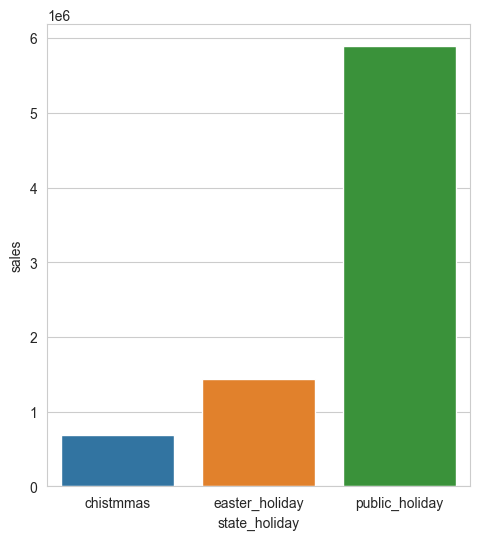

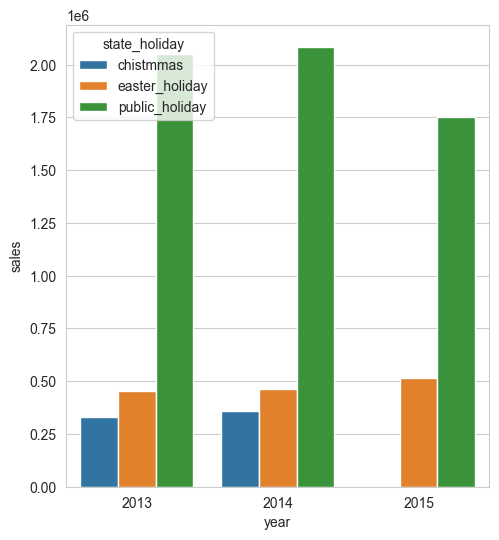

In [37]:
# filtrar os feriados
filtro=df4[df4['state_holiday'] != 'regular_day']

# plotando as vendas de acordo com os feriados para saber se no natal as lojas vendem mais
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
aux1= filtro[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data= aux1);

# checando se durante algum período (ano) teve muitas vendas no natal
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
aux2=filtro[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

#### **H8.** Lojas deveriam vender mais ao longo dos anos.
**FALSO** Lojas VENDEM MENOS ao longo dos anos.

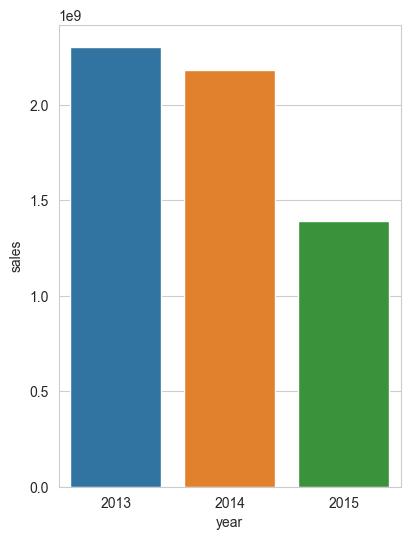

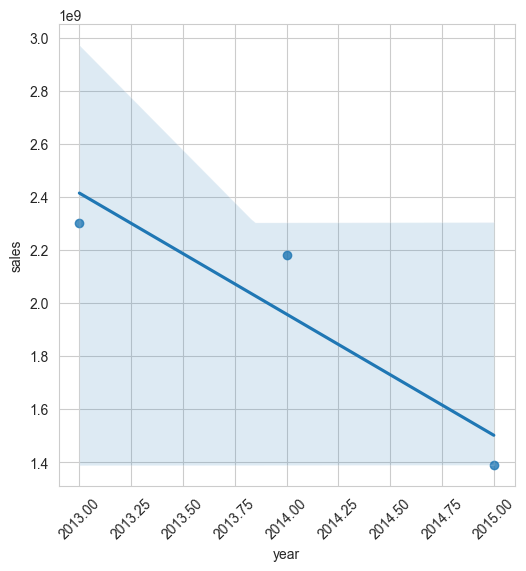

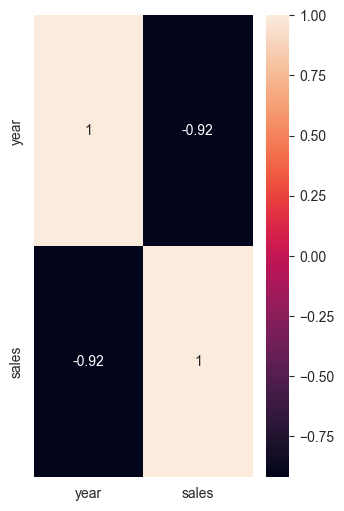

In [38]:
# verificando as vendas por cada ano
plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
aux1= df4[['year', 'sales']].groupby('year').sum().reset_index()
sns.barplot(x='year', y='sales', data=aux1);

# verificar a tendencia das vendas por ano
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1);
plt.xticks(rotation=45);

# verificar a correlação
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


#### **H9.** Lojas deveriam vender mais no segundo semestre do ano.
**FALSO** Lojas VENDEM MENOS no segundo semestre do ano.

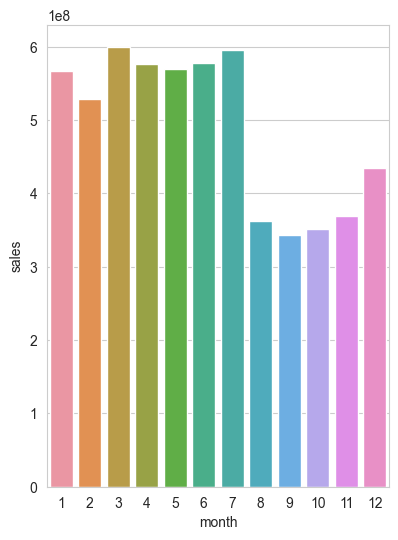

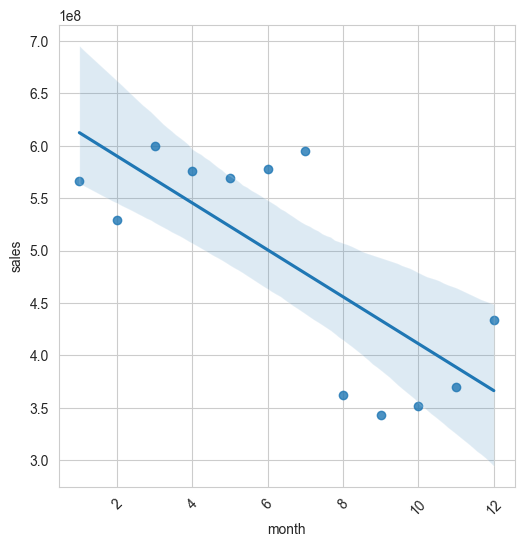

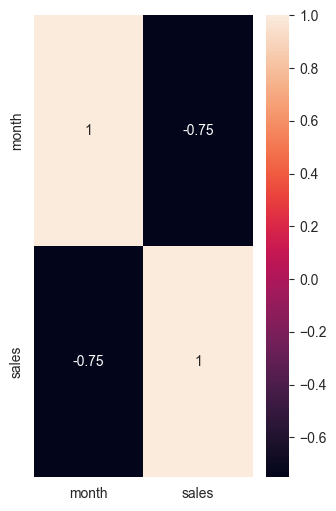

In [39]:
# verificando as vendas por cada mês
plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
aux1= df4[['month', 'sales']].groupby('month').sum().reset_index()
sns.barplot(x='month', y='sales', data=aux1);

# verificar a tendencia das vendas por mês
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1);
plt.xticks(rotation=45);

# verificar a correlação
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

#### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** Lojas VENDEM MAIS depois do dia 10 de cada mes

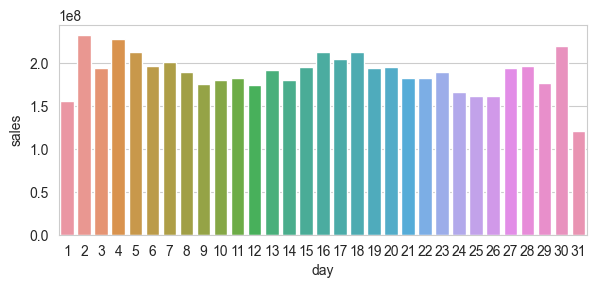

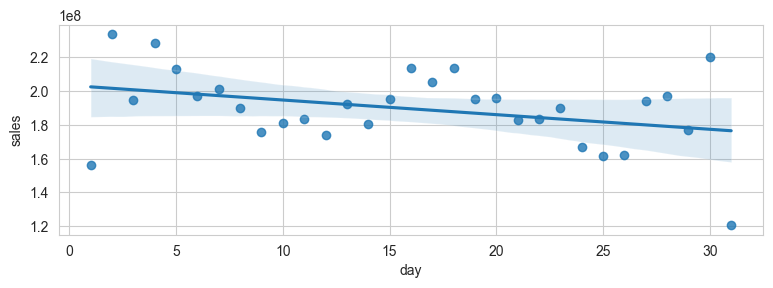

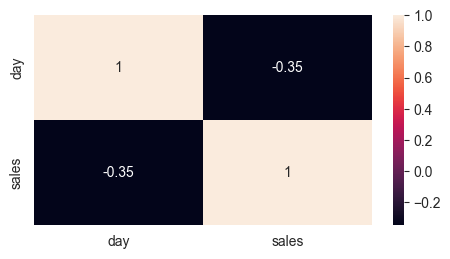

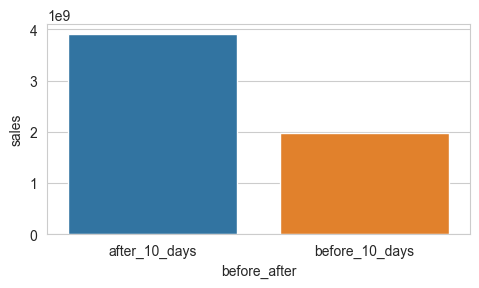

In [40]:
# verificando as vendas por cada dia
plt.figure(figsize=(15, 6))
plt.subplot(2, 2, 1)
aux1= df4[['day', 'sales']].groupby('day').sum().reset_index()
sns.barplot(x='day', y='sales', data=aux1);

# verificar a tendencia das vendas por dia
plt.figure(figsize=(20, 6))
plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1);


# verificar a correlação
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

# filtrando os dias antes do dia 10
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 4)
aux1['before_after']= aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2= aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data=aux2);

#### **H11.** Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** Lojas VENDEM MENOS nos finais de semana

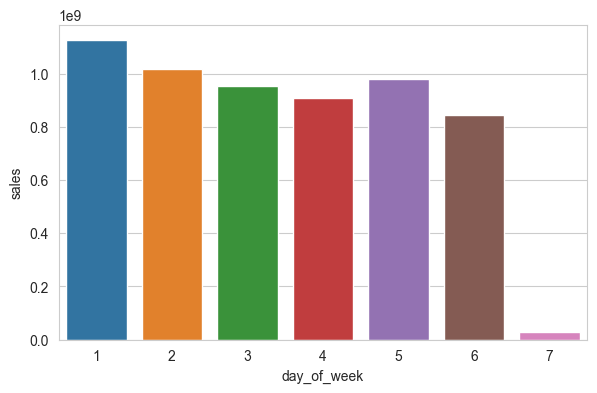

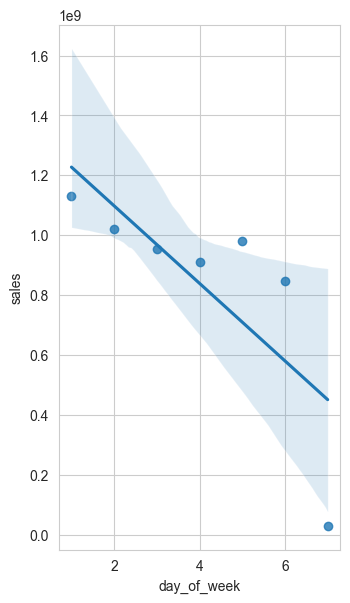

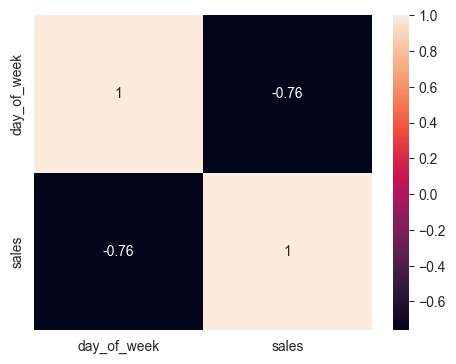

In [41]:
# verificando as vendas por final de semana
plt.figure(figsize=(15, 9))
plt.subplot(2, 2, 1)
aux1= df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(x='day_of_week', y='sales', data=aux1);

# verificar a tendencia das vendas por final de semana
plt.figure(figsize=(8, 15))
plt.subplot(2, 2, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1);


# verificar a correlação
plt.figure(figsize=(12, 9))
plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

#### **H12.** Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** Lojas VENDEM MENOS nos feriados escolares.

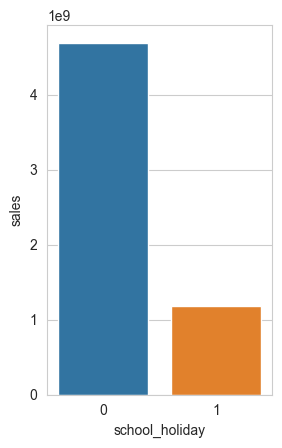

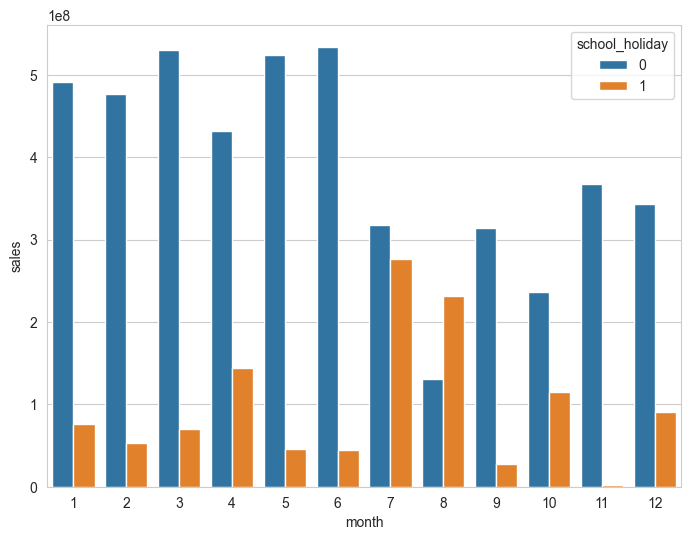

In [42]:
# verificando as vendas por feriado escolar
plt.subplot(1, 2, 1)
aux1=df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data=aux1)

#verificando as vendas por feriado escolar durante os meses
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 2)
aux2=df4[['school_holiday', 'month', 'sales']].groupby(['school_holiday', 'month']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

#### 4.2.3 Resumo das Hipoteses

In [43]:
from tabulate import tabulate

tab = [['Hipoteses', 'Conclusao', 'Relevancia'],
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Media'],
       ['H3', 'Falsa', 'Media'],
       ['H3', 'Falsa', 'Baixa'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', '-', '-'],
       ['H6', 'Falsa', 'Baixa'],
       ['H7', 'Falsa', 'Media'],
       ['H8', 'Falsa', 'Alta'],
       ['H9', 'Falsa', 'Alta'],
       ['H10', 'Falsa', 'Alta'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Verdadeira', 'Alta'],
       ['H13', 'Verdadeira', 'Baixa']
       ]

print(tabulate(tab, headers='firstow'))

f          i           r
---------  ----------  ----------
Hipoteses  Conclusao   Relevancia
H1         Falsa       Baixa
H2         Falsa       Media
H3         Falsa       Media
H3         Falsa       Baixa
H4         Falsa       Baixa
H5         -           -
H6         Falsa       Baixa
H7         Falsa       Media
H8         Falsa       Alta
H9         Falsa       Alta
H10        Falsa       Alta
H11        Verdadeira  Alta
H12        Verdadeira  Alta
H13        Verdadeira  Baixa


### 4.3 Análise Multivariada

#### 4.3.1 Atribuições Numericas

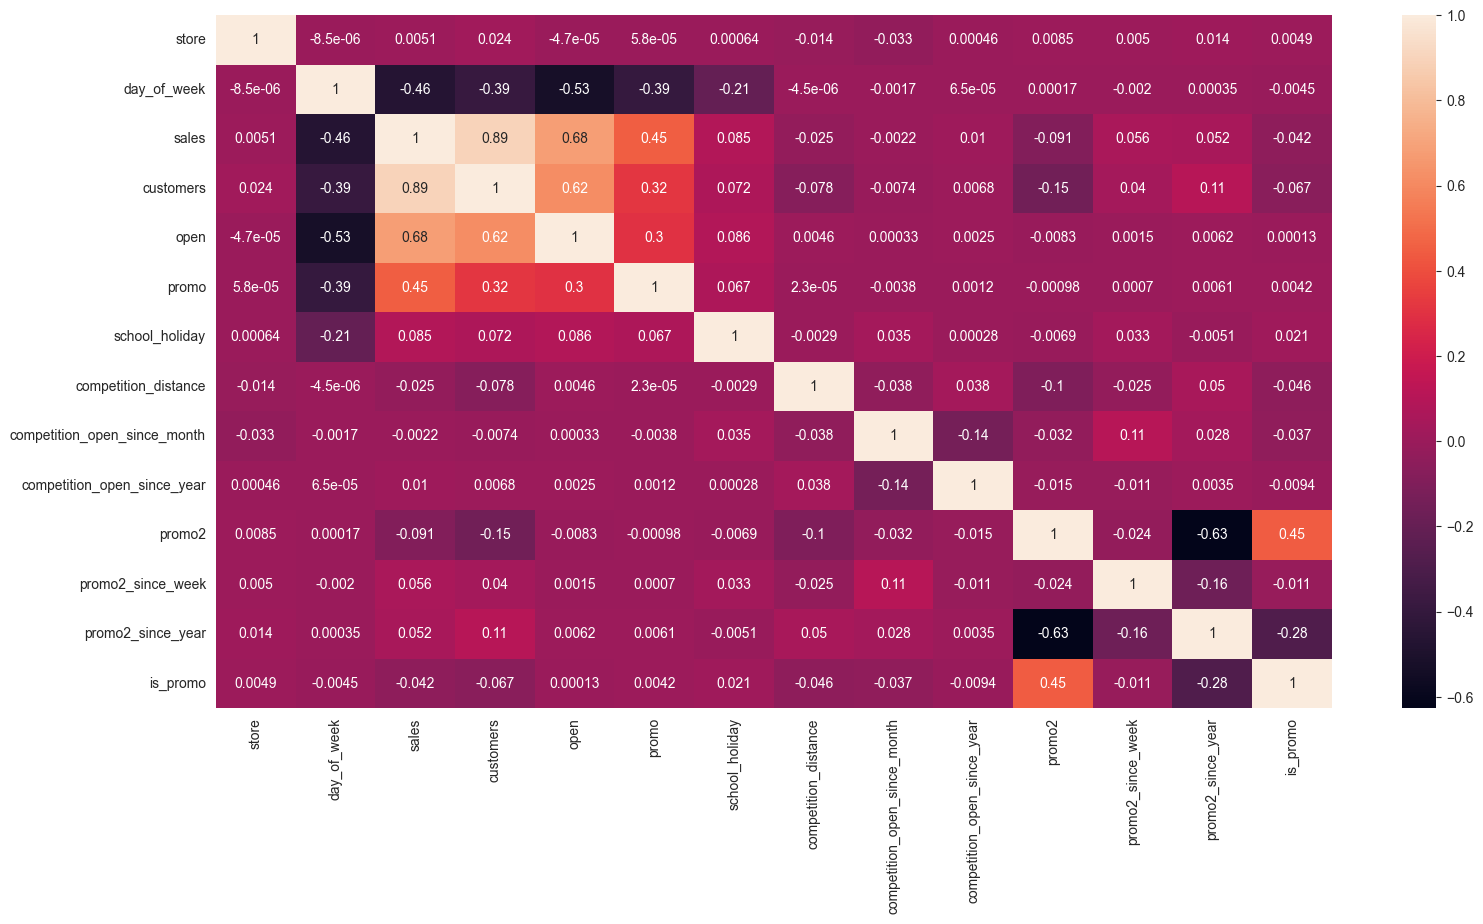

In [44]:
# verificando a correlaçao da atribuiçoes numericas conforme data set ja separado no inicio do codigo 
plt.figure(figsize=(18, 9))
correlation = num_atributes.corr(method='pearson')
sns.heatmap(correlation, annot=True ); 

#### 4.3.2 Atribuições Categoricas

In [45]:
# atualizando o data set de atribuições categoricas
cat_atribute2 = df4.select_dtypes(include='object')


<Axes: >

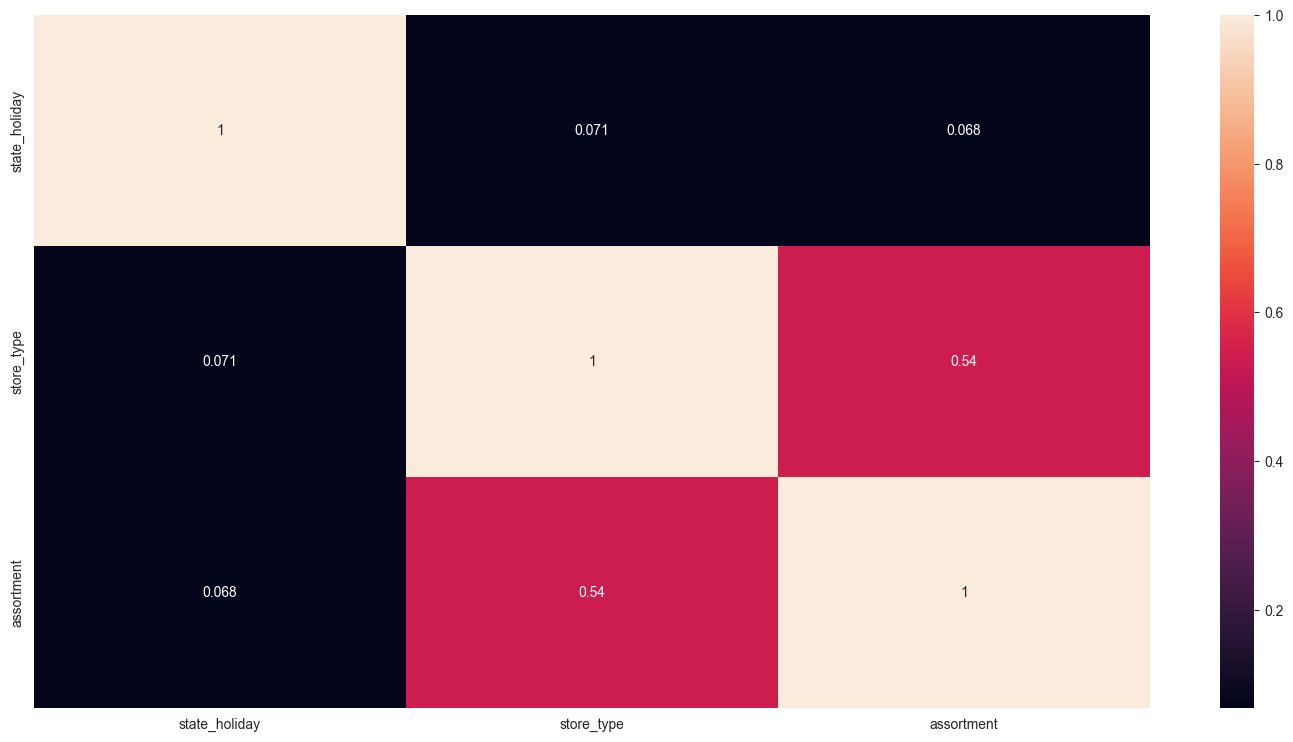

In [46]:
# criando a matrix de correlação das categorias
#calculando o cramer V das categorias
a1 = cramer_v(cat_atribute2['state_holiday'], cat_atribute2['state_holiday'])
a2 = cramer_v(cat_atribute2['state_holiday'], cat_atribute2['store_type'])
a3 = cramer_v(cat_atribute2['state_holiday'], cat_atribute2['assortment'])

a4 = cramer_v(cat_atribute2['store_type'], cat_atribute2['state_holiday'])
a5 = cramer_v(cat_atribute2['store_type'], cat_atribute2['store_type'])
a6 = cramer_v(cat_atribute2['store_type'], cat_atribute2['assortment'])

a7 = cramer_v(cat_atribute2['assortment'], cat_atribute2['state_holiday'])
a8 = cramer_v(cat_atribute2['assortment'], cat_atribute2['store_type'])
a9 = cramer_v(cat_atribute2['assortment'], cat_atribute2['assortment'])

#criando um dataframe com a matrix
matr = pd.DataFrame( {'state_holiday': [a1, a2, a3],
                      'store_type': [a4, a5, a6],
                      'assortment': [a7, a8, a9] })

# passando as colunas como index, para as linhas terem os mesmos nomes das colunas
matr = matr.set_index(matr.columns)

# criando o gráfico da matrix
plt.figure(figsize=(18, 9))
sns.heatmap(matr, annot=True)

## 5.0 Preparação dos Dados

In [47]:
df5 = df4.copy()

### 5.1 Normalização
***NÃO será necessário realizar a normalização dos dados. Não foi encotrado dados que necessitacem.***

### 5.2 Rescaling (Redimensionamento)

In [48]:
# metodos
rs = RobustScaler()
mms = MinMaxScaler() 

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competiton time month
df5['competition_time_month'] = rs.fit_transform(df4[['competition_time_month']].values)

# promo time week
df5['promo_time_week'] = mms.fit_transform(df4[['promo_time_week']].values)

# year 
df5['year'] = mms.fit_transform(df5[['year']].values)

### 5.3 Transformação

#### 5.3.1 Encoding
 

In [49]:
# realizando o encodin das variaveis categoricas

# state holiday - tecnica One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])
                
              

# store type - tecnica Label Encoder
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - tecnica Ordinal Encoding
assortment_list = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_list)

In [50]:
# as seguintes colunas foram transformadas para valores bool apos o get dummies, entao esta sendo convertida para int 
df5['state_holiday_chistmmas'] = df5['state_holiday_chistmmas'].astype(int)
df5['state_holiday_easter_holiday'] = df5['state_holiday_easter_holiday'].astype(int)
df5['state_holiday_public_holiday'] = df5['state_holiday_public_holiday'].astype(int)
df5['state_holiday_regular_day'] = df5['state_holiday_regular_day'].astype(int)   

#### 5.3.2 Transformação da Variável Resposta
 

In [51]:
# realizando a transformação atravez do logaritmo para que a variavel resposta fique proxima a uma distribuição normal
df5['sales'] =  np.log1p( df5['sales'] ) 

#### 5.3.3 Transformação de Natureza
 

In [52]:
# trasnformação os dados de data de uma forma que seja entendimo como algo ciclico, ou seja, que o algoritmo entenda o passar dos dias, meses e anos.
# day of week - transformando para entender os dias da semana 
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7) ) )

# day - tranformando para entender os dias do mes
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30) ) )

# month - tranformando para entender a continuidade de um ano apos outro ano (o ano é linear e nao ciclico)
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12) ) )

# week of year - tranformando para se entender as semanas que formam o ciclo do ano 
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52) ) )

## 6.0 Seleção de Features

In [53]:
# copia de segurança
df6 = df5.copy()

In [54]:
# excluindo as colunas que nao serao necessarias para o modelo (colunas que nao agregam para a generalização do modelo)
cols_drop = [ 'week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competiton_since', 'year_week' ]
df6 = df6.drop(cols_drop, axis=1)

#### 6.1 Split dataframe into training and test dataset

In [55]:
# sepearação dos dados por data para treino e test
# sendo necessario descobrir qual a primeira data e a ultima
# apos saber as datas, pegar a ultima data e diminuir 6 semanas para colocar no Test e o que for antes vai ser treino 
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days =6*7)



Timestamp('2015-06-19 00:00:00')

In [56]:
# do inicio da data ate 6 semanas antes sera o periodo para os dados de treino

# training dataset
X_train = df6[df6['date'] < '2015-06-19']
Y_train = X_train['sales']

#&
# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
Y_test = X_test['sales']


# print para conferir se as datas estao de acordo
print( f"Training Min Date: {X_train['date'].min()}")
print( f"Training Max Date: {X_train['date'].max()}")

print( f"\nTest Min Date: {X_test['date'].min()}")
print( f"Test Max Date: {X_test['date'].max()}" )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


#### 6.2 Filtrar as Melhores Features para o Modelo

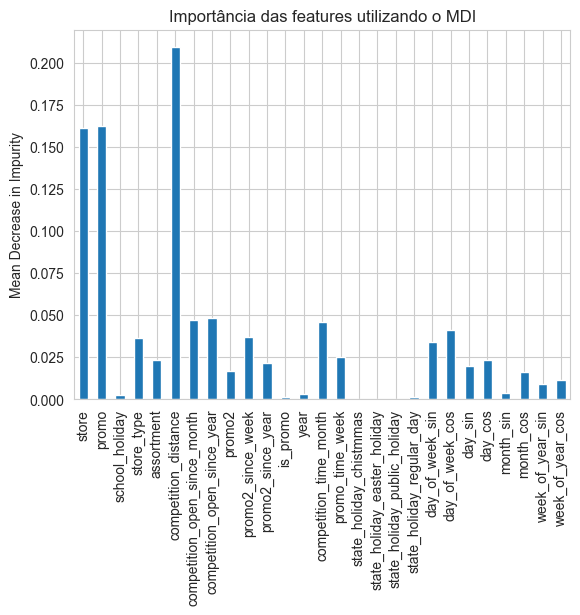

In [57]:
# utilizando um modelo de random forest para selecionar as features mais relevantes para o modelo
# training and test dataset 
X_train_n = X_train.drop(['date', 'sales'], axis=1).values
Y_train_n = Y_train.values.ravel()

# defindindo a Random Forest, nesse caso sera a Rando Forest Regressor
rf = RandomForestRegressor (n_jobs = -1)

# Pode testar mais valores de estimadores para verificar, porém a diferença na importância das features é pequena.
model_select = rf 
model_select.fit(X_train_n, Y_train_n)

# Selecionando as features de maior importância através do modelo treinado
n_features = X_train_n.shape[1]
feature_names = [f"feature {i}" for i in range(n_features)]
importances = model_select.feature_importances_
forest_importances = pd.Series(importances, index = feature_names)

# MDI: calcula a redução média da impureza de cada feature e plota em um gráfico para visualização
fig, ax = plt.subplots()
forest_importances.plot.bar(ax = ax)
ax.set_title('Importância das features utilizando o MDI')
ax.set_ylabel('Mean Decrease in Impurity')
X_train_n_columns = df6.drop(['sales', 'date'], axis = 1).columns
ax.set_xticklabels(X_train_n_columns)
plt.xticks(rotation = 90);

In [58]:
# seleção de colunas relevantes para o modelo de acordo com a seleção do modelo utilizado 
cols_select = [ 'store', 
               'promo', 
               'store_type', 
               'assortment', 
               'competition_distance', 
               'competition_open_since_month', 
               'competition_open_since_year', 
               'promo2', 
               'promo2_since_week', 
               'promo2_since_year', 
               'competition_time_month', 
               'promo_time_week', 
               'day_of_week_sin', 
               'day_of_week_cos', 
               'day_sin', 
               'day_cos', 
               'month_sin', 
               'month_cos', 
               'week_of_year_sin', 
               'week_of_year_cos' ]

# colunas para adicionar
feat_to_add = ['date', 'sales']

# final features (com todas as colunas)
cols_select_full = cols_select.copy()
cols_select_full.extend(feat_to_add)
#cols_select

In [66]:
#a = pd.DataFrame(forest_importances).reset_index()
#a = a.rename(columns={0: 'importance'})
#sorted_a = a.sort_values(by='importance', ascending=False)
#sorted_a

## 7.0 Modelos de Machine Learning 

In [59]:
# selecionando as colunas que achamos relevantes para o modelo (separação do dados que vao para treinar o modelo)
x_train = X_train[cols_select]
x_test = X_test[cols_select]

# separação dos dados para o cross validation
x_training = X_train[cols_select_full]

### 7.1 Avarage Model

In [60]:
# criação de um basline de comparação de performance para os modelos de machine learning
# media de vendas de cada loja
aux1 = x_test.copy()
aux1['sales'] = Y_test.copy()

#prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns= {'sales': 'predictions'})
aux1 = pd.merge(aux1,aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

#perfomance
baseline_result = ml_error('Avarage Model', np.expm1(Y_test), np.expm1 (yhat_baseline))
baseline_result


,Model Name,MAE,MAPE,RMSE
0,Avarage Model,1354.800353,0.2064,1835.135542


### 7.2 Linear Regression Model

In [61]:
#treinando o modelo
lr = LinearRegression().fit (x_train, Y_train)

# predicição
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error ('Linear Regression', np.expm1(Y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


#### 7.2.1 Linear Regression - Cross Validation

In [62]:
# avaliando a perfomance do modelo 
modelo = LinearRegression()
lr_result_cv= cross_validation(x_training, 5, 'Linear Regressor', modelo, verbose=False)
lr_result_cv

,Model Name,MAE - Mean/Std,MAPE - Mean/Std,RMSE - Mean/Std
0,Linear Regressor,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


### 7.3 Linear Regression Regularized Model (Lasso)

In [63]:
# treinando modelo
lrr = Lasso(alpha= 0.01).fit (x_train, Y_train)

# predição
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error ('Linear Regression - Lasso', np.expm1(Y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.45174


#### 7.3.1 Lasso - Cross Validation

In [64]:
# avaliando a perfomance do modelo
modelo = Lasso()
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', modelo, verbose=False)
lrr_result_cv

,Model Name,MAE - Mean/Std,MAPE - Mean/Std,RMSE - Mean/Std
0,Lasso,2388.68 +/- 398.48,0.34 +/- 0.01,3369.37 +/- 567.55


### 7.4 Random Forest Regressor 

In [65]:
# treinando o modelo
rf = RandomForestRegressor(n_estimators=100, n_jobs= -1, random_state=42).fit (x_train, Y_train)

# predição
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error ('Random Forest', np.expm1(Y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest,680.090442,0.099972,1012.417997


#### 7.4.1 Random Forest Regressor - Cross Validation

In [66]:
# avaliando a perfomance do modelo
rf_cv = RandomForestRegressor(n_estimators=100, n_jobs= -1, random_state=42)

rf_result_cv = cross_validation( x_training, 5, 'Random Forest', rf_cv, verbose=True )
rf_result_cv 

KFold Number: 5
KFold Number: 4
KFold Number: 3
KFold Number: 2
KFold Number: 1


,Model Name,MAE - Mean/Std,MAPE - Mean/Std,RMSE - Mean/Std
0,Random Forest,837.49 +/- 218.58,0.12 +/- 0.02,1256.48 +/- 319.57


### 7.6 Comparação da Performance dos modelos

#### 7.6.1  Performance dos modelos 

In [67]:
# montando uma tabela com os resultados das perforance dos modelos treinados 
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result ] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest,680.090442,0.099972,1012.417997
0,Avarage Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451740


#### 7.6.2 Performance  Real apos Cross-Validation

In [68]:
# montando uma tabela com os resultados das perforance dos modelos treinados e avaliados com validação cruzada
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv] )
modelling_result_cv

,Model Name,MAE - Mean/Std,MAPE - Mean/Std,RMSE - Mean/Std
0,Linear Regressor,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2388.68 +/- 398.48,0.34 +/- 0.01,3369.37 +/- 567.55
0,Random Forest,837.49 +/- 218.58,0.12 +/- 0.02,1256.48 +/- 319.57


## 8.0  Tunagem de Hiperparâmetros

### 8.1 Random Search

In [69]:
# dicionário com os parametros q serao testados e valores escolhidos 
param = { 'n_estimators': [50, 100, 200, 300, 400],
         'max_deph': [10, 20, 30, 40, 50],
         'min_samples_leaf': [1, 2, 4],
          'min_samples_split': [2, 5, 10] }

# constante que diz quantas interações terão
MAX_EVAL = 3

In [75]:
# dtaframe que vai armazenar os valores da perfomance junto com os valores dos parametros
final_result = pd.DataFrame()

# passando todos os parametros atraves do for para verificar quais sao os melhores
for i in range(MAX_EVAL):
    # escolhe os valores aleatorios para os parametros 
    hp = { k: random.sample(v, 1)[0] for k, v in param.items() }
    print(hp)

    # modelo
    rf_rs = RandomForestRegressor( n_estimators=hp['n_estimators'],
                                    max_depth= hp['max_deph'],
                                    min_samples_leaf= hp['min_samples_leaf'],
                                    min_samples_split= hp['min_samples_split'],
                                    n_jobs= -1, 
                                    random_state=42 )

    # performance
    result_rs = cross_validation (x_training, 3, 'Random Forest', rf_rs, verbose=True)
    final_result = pd.concat([final_result, result_rs])


final_result

{'n_estimators': 50, 'max_deph': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}
KFold Number: 3
KFold Number: 2
KFold Number: 1
{'n_estimators': 300, 'max_deph': 40, 'min_samples_leaf': 1, 'min_samples_split': 10}
KFold Number: 3
KFold Number: 2
KFold Number: 1
{'n_estimators': 200, 'max_deph': 50, 'min_samples_leaf': 2, 'min_samples_split': 5}
KFold Number: 3
KFold Number: 2
KFold Number: 1


,Model Name,MAE - Mean/Std,MAPE - Mean/Std,RMSE - Mean/Std
0,Random Forest,1657.31 +/- 137.47,0.23 +/- 0.0,2368.73 +/- 220.15
0,Random Forest,694.65 +/- 126.68,0.1 +/- 0.01,1048.51 +/- 200.26
0,Random Forest,690.57 +/- 126.01,0.1 +/- 0.01,1039.56 +/- 199.8


### 8.2 Modelo Final Treinado

In [76]:
# melhores parametros selecionados apos a tunagem 
param_tuned = { 'n_estimators': 200 ,
                'max_deph': 40 ,
                'min_samples_leaf': 2,
                'min_samples_split': 2 }

In [77]:
# aplicação dos melhores parametros para otimizar o melhor modelo e medir a perfomance final 
# model
rf_tuned = RandomForestRegressor(n_estimators=param_tuned['n_estimators'],
                                max_depth= param_tuned['max_deph'],
                                min_samples_leaf= param_tuned['min_samples_leaf'],
                                min_samples_split= param_tuned['min_samples_split'],
                                n_jobs= -1, 
                                random_state=42).fit (x_train, Y_train)

# predicition
yhat_rf_tuned = rf_tuned.predict(x_test)

# performance
result_rf_tuned = ml_error ('Random Forest', np.expm1(Y_test), np.expm1(yhat_rf_tuned))
result_rf_tuned 

,Model Name,MAE,MAPE,RMSE
0,Random Forest,668.90184,0.098417,995.86423


## 9.0 Tradução e Interpretação do Resultado

In [78]:
# seleção das colunas usadas para treinar o modelo e atribuindo a uma nova variavel
df7 = X_test[cols_select_full]

# rescale para voltar os dados para escala original (reverso do logaritimo)
df7['sales'] = np.expm1(df7['sales'])
df7['predictions'] = np.expm1(yhat_rf_tuned)

/var/folders/5q/g0x8rcyn6x17pcrrtzhh8vs80000gn/T/ipykernel_1725/3149479641.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df7['sales'] = np.expm1(df7['sales'])
/var/folders/5q/g0x8rcyn6x17pcrrtzhh8vs80000gn/T/ipykernel_1725/3149479641.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df7['predictions'] = np.expm1(yhat_rf_tuned)


### 9.1 Desempenho no Negócio

In [79]:
# somar as predições feitas pelo modelo
df8 = df7[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE e MPE
df8_ax = df7[['store', 'sales', 'predictions']].groupby('store').apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename(columns={ 0: 'MAE'})
df8_ax2 = df7[['store', 'sales', 'predictions']].groupby('store').apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename(columns={ 0: 'MAPE'})

# merge das tabelas
df8_axs = pd.merge(df8_ax, df8_ax2, how='inner', on='store')
df_end = pd.merge(df8, df8_axs, how='inner', on='store')

#criando pior cenário
df_end['pior_cenario'] = df_end['predictions'] - df_end['MAE']
df_end['melhor_cenario'] = df_end['predictions'] + df_end['MAE']

# ordenando as colunas
df_end = df_end[['store', 'predictions', 'pior_cenario', 'melhor_cenario', 'MAE', 'MAPE']]

# colocando em ordem decrescente
df_end.sort_values('MAPE', ascending=False).head(5)

,store,predictions,pior_cenario,melhor_cenario,MAE,MAPE
291,292,108566.566411,105001.186238,112131.946585,3565.380174,0.611381
908,909,246652.819164,239627.639694,253677.998634,7025.179470,0.483278
549,550,259078.901307,257275.498569,260882.304045,1803.402738,0.362747
875,876,212487.042964,208614.361692,216359.724236,3872.681272,0.299818
721,722,353837.333554,351822.702918,355851.964191,2014.630637,0.270514


<Axes: xlabel='store', ylabel='MAPE'>

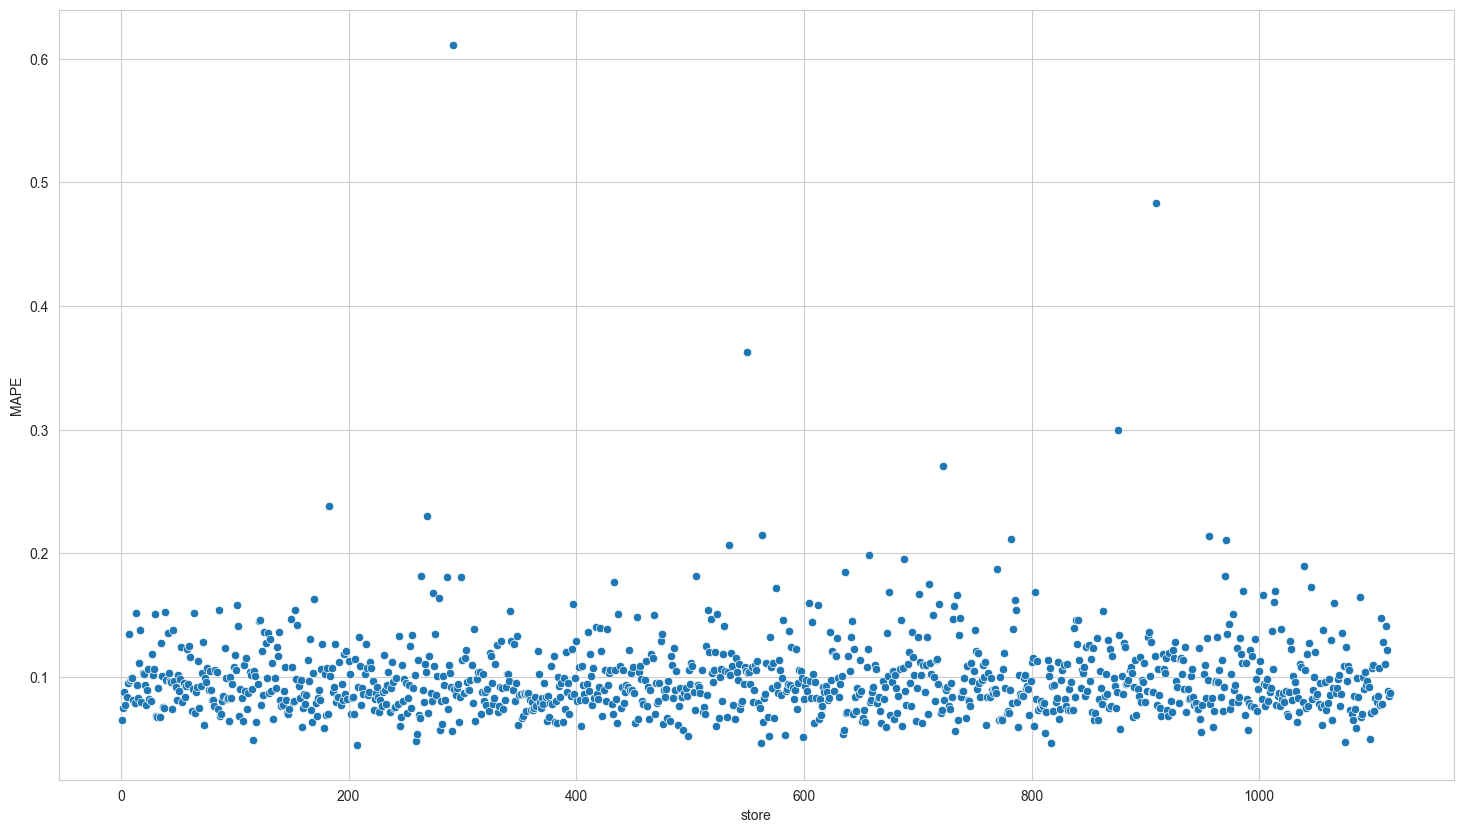

In [80]:
# plotando de forma visual
plt.figure(figsize=(18, 10))
sns.scatterplot(df_end, x='store', y='MAPE')

### 9.2 Desempenho Total

In [81]:
# panomrama geral da perfomance traduzido para valor monetario

df_end_p = df_end[['predictions', 'melhor_cenario', 'pior_cenario']].apply(lambda x: np.sum(x), axis= 0).reset_index().rename(columns= {'index': 'Cenário', 0: 'Valores'})
df_end_p['Valores'] = df_end_p['Valores'].map( 'R${:,.2f}'.format )
df_end_p

,Cenário,Valores
0,predictions,"R$288,969,161.58"
1,melhor_cenario,"R$289,718,727.98"
2,pior_cenario,"R$288,219,595.18"


### 9.3 Machine Learning Perfomance

In [82]:
df7['error'] = df7['sales'] - df7['predictions']
df7['error_rate'] = df7['predictions'] / df7['sales']

/var/folders/5q/g0x8rcyn6x17pcrrtzhh8vs80000gn/T/ipykernel_1725/1370162162.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df7['error'] = df7['sales'] - df7['predictions']
/var/folders/5q/g0x8rcyn6x17pcrrtzhh8vs80000gn/T/ipykernel_1725/1370162162.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df7['error_rate'] = df7['predictions'] / df7['sales']


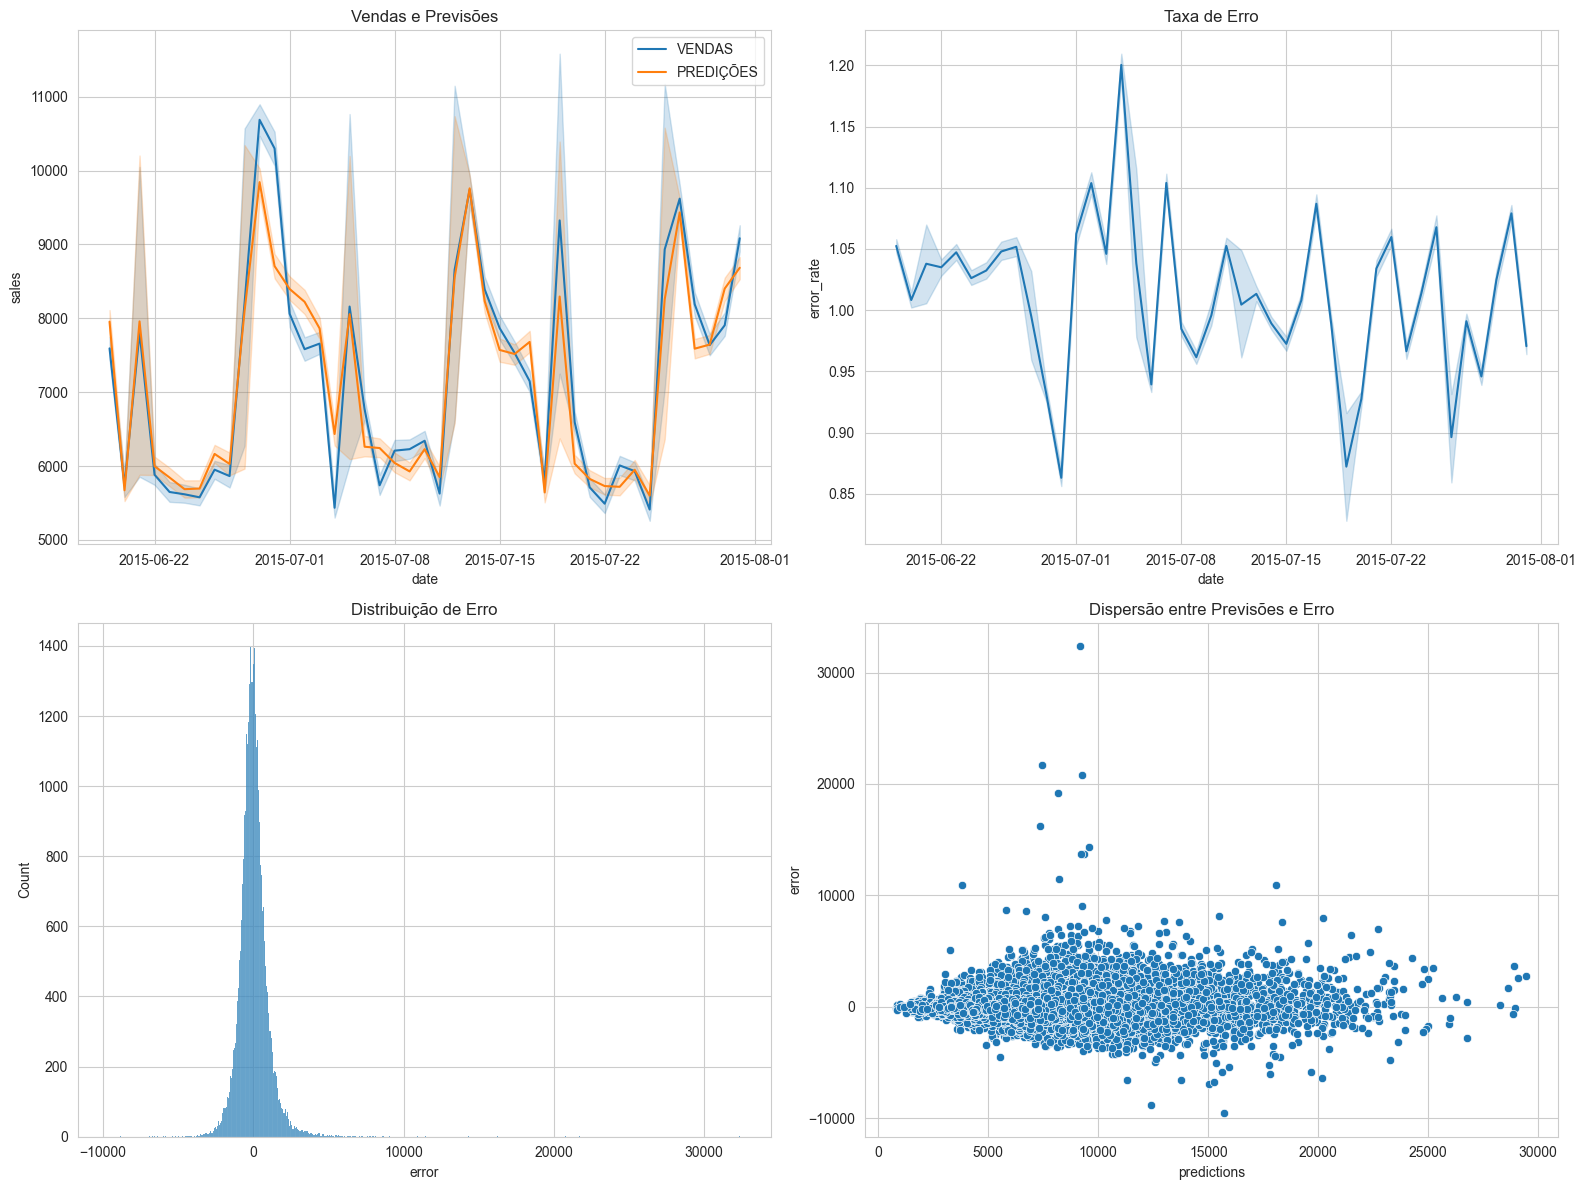

In [83]:

# plotando gráficos para analisar a performance do modelo
# Configurar o layout de subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Vendas e Previsões
sns.lineplot(x='date', y='sales', data=df7, label='VENDAS', ax=axes[0, 0])
sns.lineplot(x='date', y='predictions', data=df7, label='PREDIÇÕES', ax=axes[0, 0])
axes[0, 0].set_title('Vendas e Previsões')

# Taxa de Erro
sns.lineplot(x='date', y='error_rate', data=df7, ax=axes[0, 1])
axes[0, 1].set_title('Taxa de Erro')

# Distribuição de Erro
sns.histplot(df7['error'], ax=axes[1, 0])
axes[1, 0].set_title('Distribuição de Erro')

# Dispersão entre Previsões e Erro
sns.scatterplot(x=df7['predictions'], y=df7['error'], ax=axes[1, 1])
axes[1, 1].set_title('Dispersão entre Previsões e Erro')

# Ajustar o layout
plt.tight_layout()
plt.show()
